# Investigating How Data Scientists Answered the Stack Overflow Survey

## Background
I am investigating the 2017 Stack Overflow survey results. A brief description of the survey and the relevant files can be found on [Kaggle](https://www.kaggle.com/stackoverflow/so-survey-2017).

## Questions
Since I am taking the Data Science Nanodegree program from Udacity, I am interested in how data scientists answered the questions in this survey.  The questions I will explore are:
1. What developer types overlap with data scientists?
2. What effect does being a data scientist have on salary?
3. What types of education do data scientists recommend?

## Data Gathering

In [1]:
# Import packages and read in data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv('survey_results_public.csv')
schema = pd.read_csv('survey_results_schema.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Assessment & Cleaning

In [2]:
# Look at some basic descriptive statistics...
display(df.describe())
display(df.shape)

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,19102.000000,16102.000000,15253.000000,7721.000000,13452.000000,5009.000000,818.000000
mean,9551.500000,7.343932,7.000721,3.685922,8.357865,58341.398571,32231.521687
std,5514.416757,1.919330,2.128648,7.330691,1.405546,40753.384986,28543.877274
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4776.250000,6.000000,6.000000,0.000000,8.000000,27956.989247,4716.459735
50%,9551.500000,8.000000,7.000000,1.000000,8.000000,51612.903226,29784.946237
75%,14326.750000,9.000000,8.000000,3.000000,9.000000,83333.333333,50000.000000
max,19102.000000,10.000000,10.000000,40.000000,10.000000,195000.000000,120000.000000


(19102, 154)

There are 19,102 rows in the dataset, with each corresponding to a single respondent.  Of the 154 columns, however, there are only 6 columns that have numerical data, which means that most of the columns have categorical responses, including the column that I am interested in exploring first: 'DeveloperType'.

In [3]:
# Look at the 'DeveloperType' question
print(schema.loc[schema['Column']=='DeveloperType','Question'].values)

['Which of the following best describe you?']


In [4]:
# Look at the first 10 rows of DeveloperType:
df['DeveloperType'].head(10)

0                                                  NaN
1                                                  NaN
2                                                Other
3                                                  NaN
4    Mobile developer; Graphics programming; Deskto...
5                                                  NaN
6                                                  NaN
7                                        Web developer
8                      Web developer; Mobile developer
9     Mobile developer; Desktop applications developer
Name: DeveloperType, dtype: object

Not every respondent provided a developer type, meaning that my sample size will be less than the 19,102 in the dataset.  I also see some respondents provided multiple answers, separated by semicolons, which need to be parsed out.

In [5]:
# Create a function to identify unique responses in DeveloperType
def unique_responses(df_column):
    '''
    Identifies the unique responses in a column of the Stack Overflow dataset
    
    df_column: pandas Series, the column from the pandas Dataframe to parse
    
    returns response_set, a set of the unique responses
    '''
    # Initialize the set
    response_set = set()
    
    # Loop through the column
    for response in df_column:
        # Split the response by semicolon and a space (; ) into multiple developer types
        dev_types = str(response).split('; ')
        # For each developer type in the response, add it to the set of responses
        for dev_type in dev_types:
            response_set.add(dev_type)

    return response_set

In [6]:
# View unique responses in DeveloperType
developer_responses = unique_responses(df['DeveloperType'])
developer_responses

{'Data scientist',
 'Database administrator',
 'Desktop applications developer',
 'DevOps specialist',
 'Developer with a statistics or mathematics background',
 'Embedded applications/devices developer',
 'Graphic designer',
 'Graphics programming',
 'Machine learning specialist',
 'Mobile developer',
 'Other',
 'Quality assurance engineer',
 'Systems administrator',
 'Web developer',
 'nan'}

There are 15 different unique responses to the 'DeveloperType' question, including 'Other' and 'nan' (meaning the respondent didn't answer this question). I am curious how 'Data scientist' compares to the rest of the types listed.  But first, I want to know how many respondents fall under each developer type.

In [7]:
# Create a dictionary of the number of responses for each DeveloperType

# Initialize a dictionary for counting
response_dict = dict.fromkeys(developer_responses,0)
# Loop through each row of the dataframe
for response in df['DeveloperType']:
    # For each developer type in the response, increment the dictionary count by 1
    for dev_type in str(response).split('; '):
        response_dict[dev_type] += 1

response_dict

{'Graphics programming': 584,
 'Mobile developer': 2905,
 'Developer with a statistics or mathematics background': 1479,
 'Systems administrator': 1479,
 'DevOps specialist': 1505,
 'Embedded applications/devices developer': 1174,
 'Desktop applications developer': 3869,
 'Other': 996,
 'Quality assurance engineer': 429,
 'Database administrator': 1827,
 'nan': 5330,
 'Web developer': 10086,
 'Data scientist': 1077,
 'Graphic designer': 439,
 'Machine learning specialist': 488}

In [8]:
# Visualize the response dictionary in a sorted dataframe
response_df = pd.DataFrame.from_dict(response_dict,orient='index',columns=['Count'])
response_df.sort_values(by='Count',ascending=False)

,Count
Web developer,10086
nan,5330
Desktop applications developer,3869
Mobile developer,2905
Database administrator,1827
DevOps specialist,1505
Developer with a statistics or mathematics background,1479
Systems administrator,1479
Embedded applications/devices developer,1174
Data scientist,1077


In [9]:
# Since the respondents that did not answer this question do not provide any information to help answer my questions,
# I will drop that response from my dataframe
response_df.drop(index='nan',inplace=True)

In [10]:
# Add a column to the dataframe to reflect frequency of respondents by developer type
# NOTE: This is the number of people (respondents) who included each developer type in their response
num_respondents = 19102-5330 # Total number of respondents minus 'nan's
response_df['Respondent_Freq'] = response_df['Count']/num_respondents

In [11]:
# Create a sorted dataframe for easier plotting
response_df_sorted = response_df.sort_values(by='Count',ascending=False)

# Visualize
response_df_sorted

,Count,Respondent_Freq
Web developer,10086,0.732356
Desktop applications developer,3869,0.280932
Mobile developer,2905,0.210935
Database administrator,1827,0.132660
DevOps specialist,1505,0.109280
Developer with a statistics or mathematics background,1479,0.107392
Systems administrator,1479,0.107392
Embedded applications/devices developer,1174,0.085245
Data scientist,1077,0.078202
Other,996,0.072321


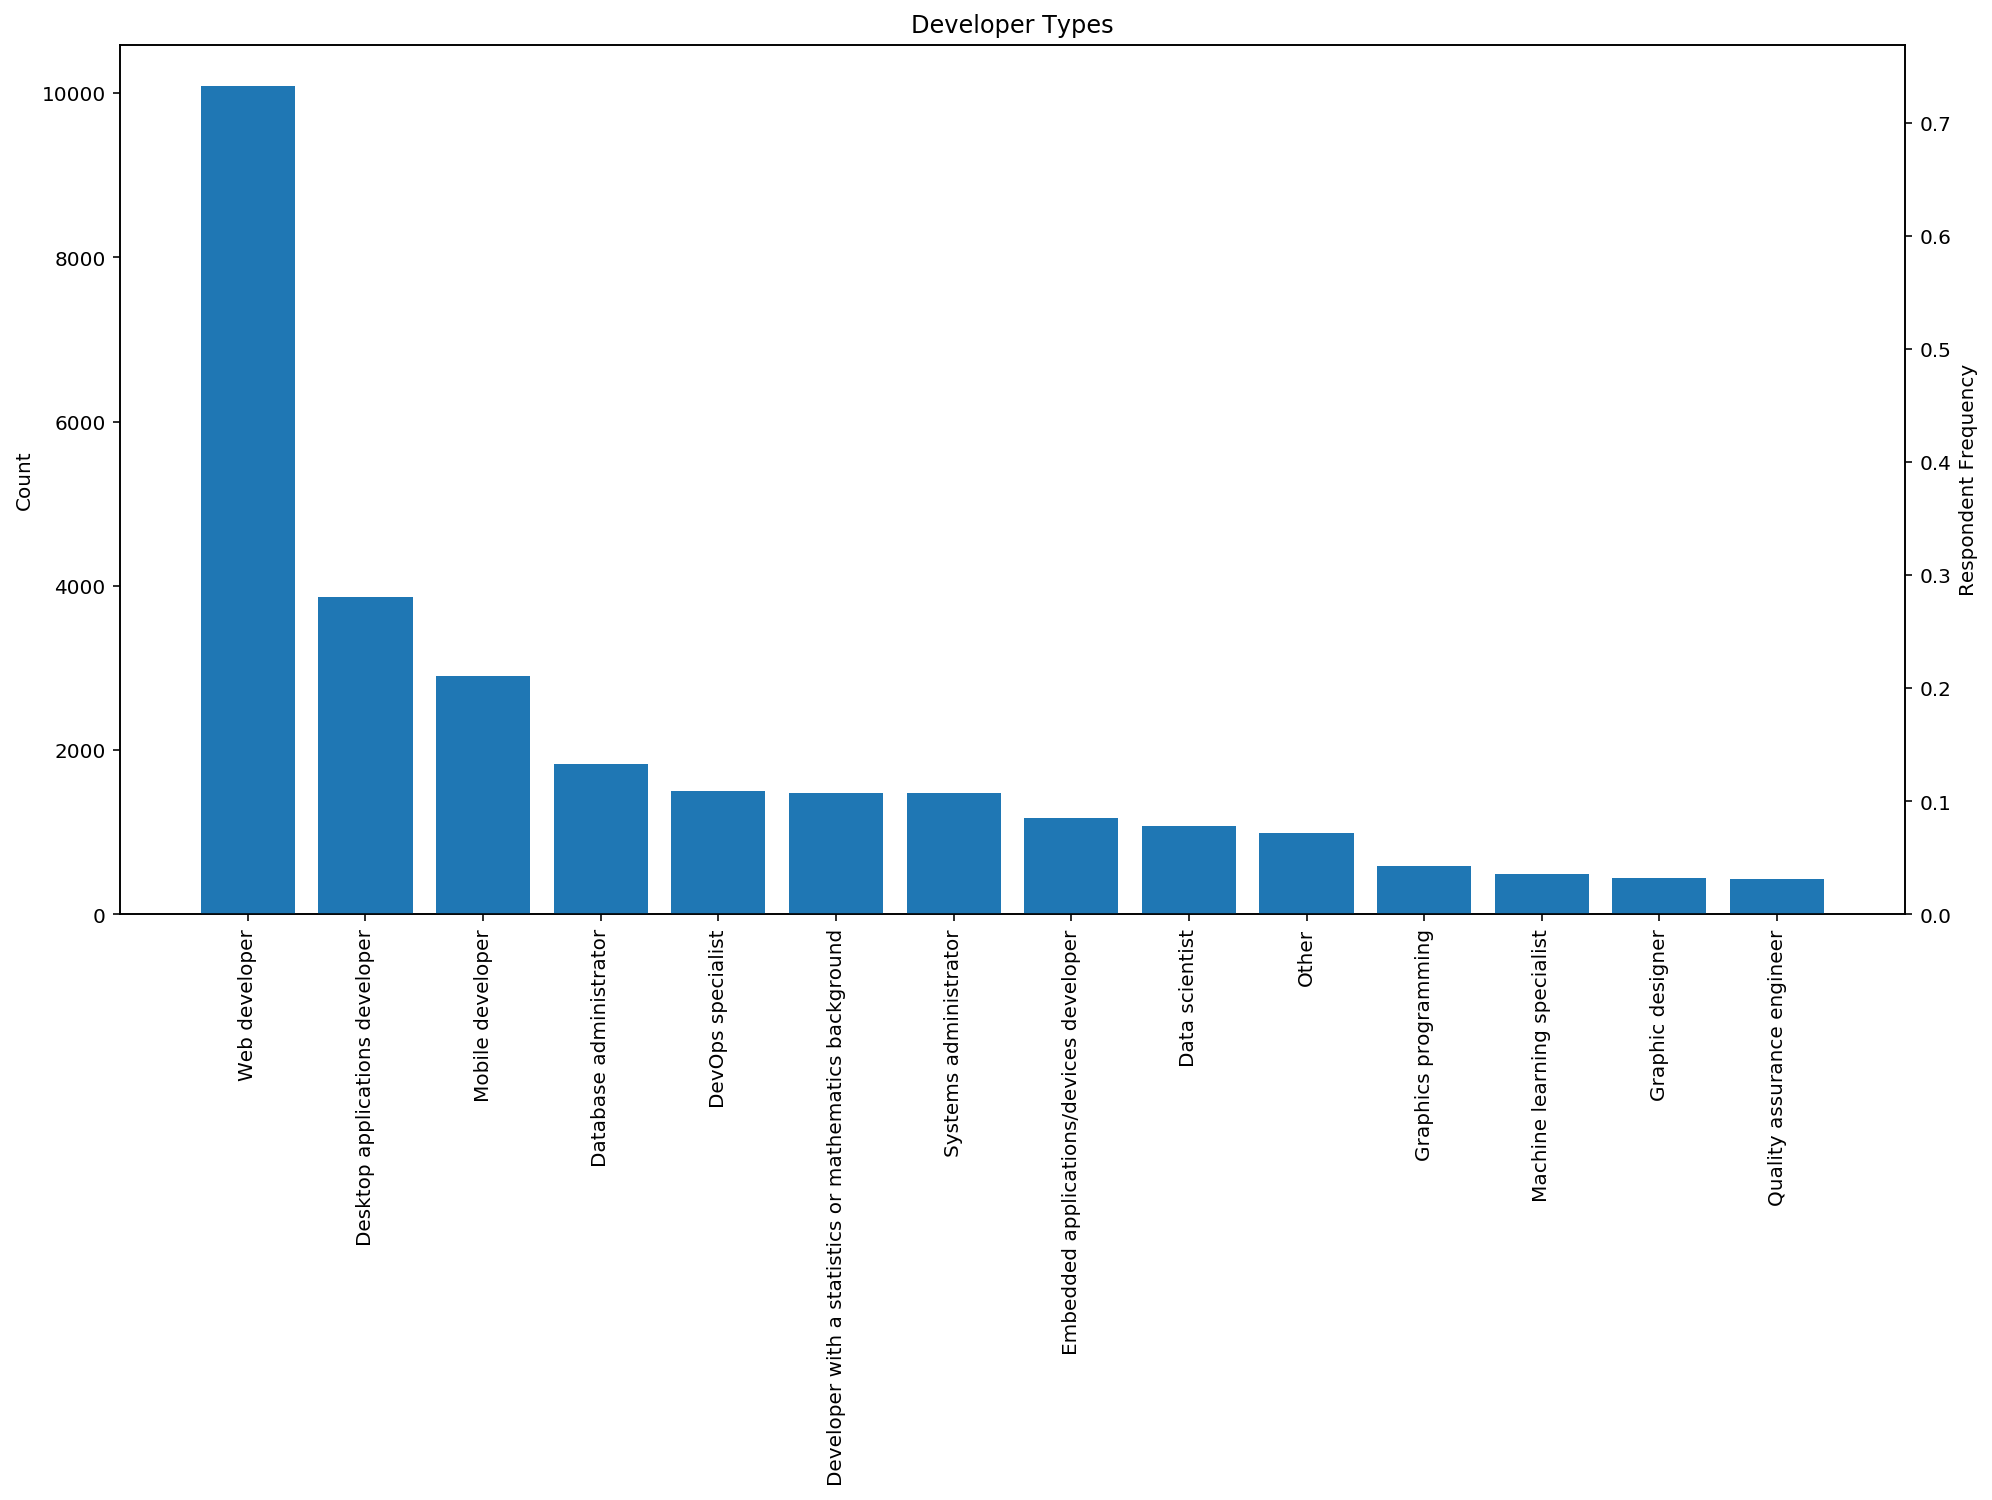

In [12]:
# Plot responses by developer type
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
ax1.bar(response_df_sorted.index,response_df_sorted['Count'])
ax2 = ax1.twinx()
ax2.bar(response_df_sorted.index,response_df_sorted['Respondent_Freq'])
ax1.set_xticklabels(response_df_sorted.index, rotation=90)
ax1.set_ylabel('Count')
ax2.set_ylabel('Respondent Frequency')
ax1.set_title('Developer Types')
plt.show()

In [13]:
num_responses = response_df_sorted['Count'].sum()
print('The number of respondents:',num_respondents)
print('The number of responses:',num_responses)
print('The average number of developer types per respondent: {:.2f}'.format(num_responses/num_respondents))

The number of respondents: 13772
The number of responses: 28337
The average number of developer types per respondent: 2.06


The most common response was 'Web developer' with over 10,000 responses, making up over 70% of respondents.  Data scientists made up 1077 responses (7.8% of respondents).  Since the average number of developer types per respondent was approximately 2, I am curious what other developer types the respondents that selected 'Data scientist' included in their responses.

## Data Analysis
### Developer Types
This initial breakdown of the developer types counted each type in isolation.  Next, I need to identify which developer type(s) each respondent selected.  I will perform onehot encoding, creating 15 new columns in the dataframe to capture whether each respondent selected a particular developer type.  Pandas has a very convenient function called *get_dummies* for this process, but it will not work on the 'DeveloperType' column because it has multiple responses in a given row and the function assumes one response per row.

In [14]:
# Write a function to loop through every row and assign 1's to the developer type columns included in 'DeveloperType'
def generate_onehot(df,column,separator):
    '''
    Loops through the dataframe (df) and onehot encodes the column
    This function is intended for onehot encoding a column that has multiple entries in a single column that need to be parsed
    Drops the original column
    
    df: pandas Dataframe
    column: string, the column in df to be encoded
    separator: string, the separator between multiple entries in a single row
    
    returns: df, pandas Dataframe with onehot encoded columns and without the original column
    '''
    # Copy the dataframe
    df_copy = df.copy()
    
    # Initialize the set of possible responses
    response_set = set()
    
    # Loop through the column
    for response in df_copy[column]:
        # Split the response by the separator into multiple entries
        entries = str(response).split(separator)
        # For each entry in the response, add it to the set of responses
        for entry in entries:
            response_set.add(entry)
    
    # Add new columns for the responses with all rows containing 0
    for new_column in list(response_set):
        df_copy[new_column] = 0
    
    # Loop through the rows of the dataframe
    for row in range(len(df_copy)):
        # Split the response by the separator into multiple entries
        entries = str(df_copy.loc[row,column]).split(separator)
        # Set the value in the new column equal to 1
        for entry in entries:
            df_copy.loc[row,entry] = 1
    
    # Drop the original column
    df_copy.drop(columns=column, inplace=True)
    
    return df_copy

In [15]:
# Call the generate_onehot function on a subset of the original dataset
encoded_df = df[['DeveloperType','Salary','JobSatisfaction']]
encoded_df = generate_onehot(encoded_df,'DeveloperType','; ')

In [16]:
# View the first 10 rows of the encoded dataframe to verify onehot encoding
encoded_df.head(10)

,Salary,JobSatisfaction,Graphics programming,Mobile developer,Developer with a statistics or mathematics background,Systems administrator,DevOps specialist,Embedded applications/devices developer,Desktop applications developer,Other,Quality assurance engineer,Database administrator,nan,Web developer,Data scientist,Graphic designer,Machine learning specialist
0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,113750.0,9.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,NaN,3.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,NaN,8.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
5,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,NaN,6.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,NaN,7.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,NaN,6.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
9,NaN,8.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [17]:
# Drop the 'nan' column
encoded_df.drop(columns='nan', inplace=True)
# Add a row to calculate how many Developer Types each person provided
encoded_df['NumDevTypes'] = encoded_df.iloc[:,-14:].sum(axis=1)

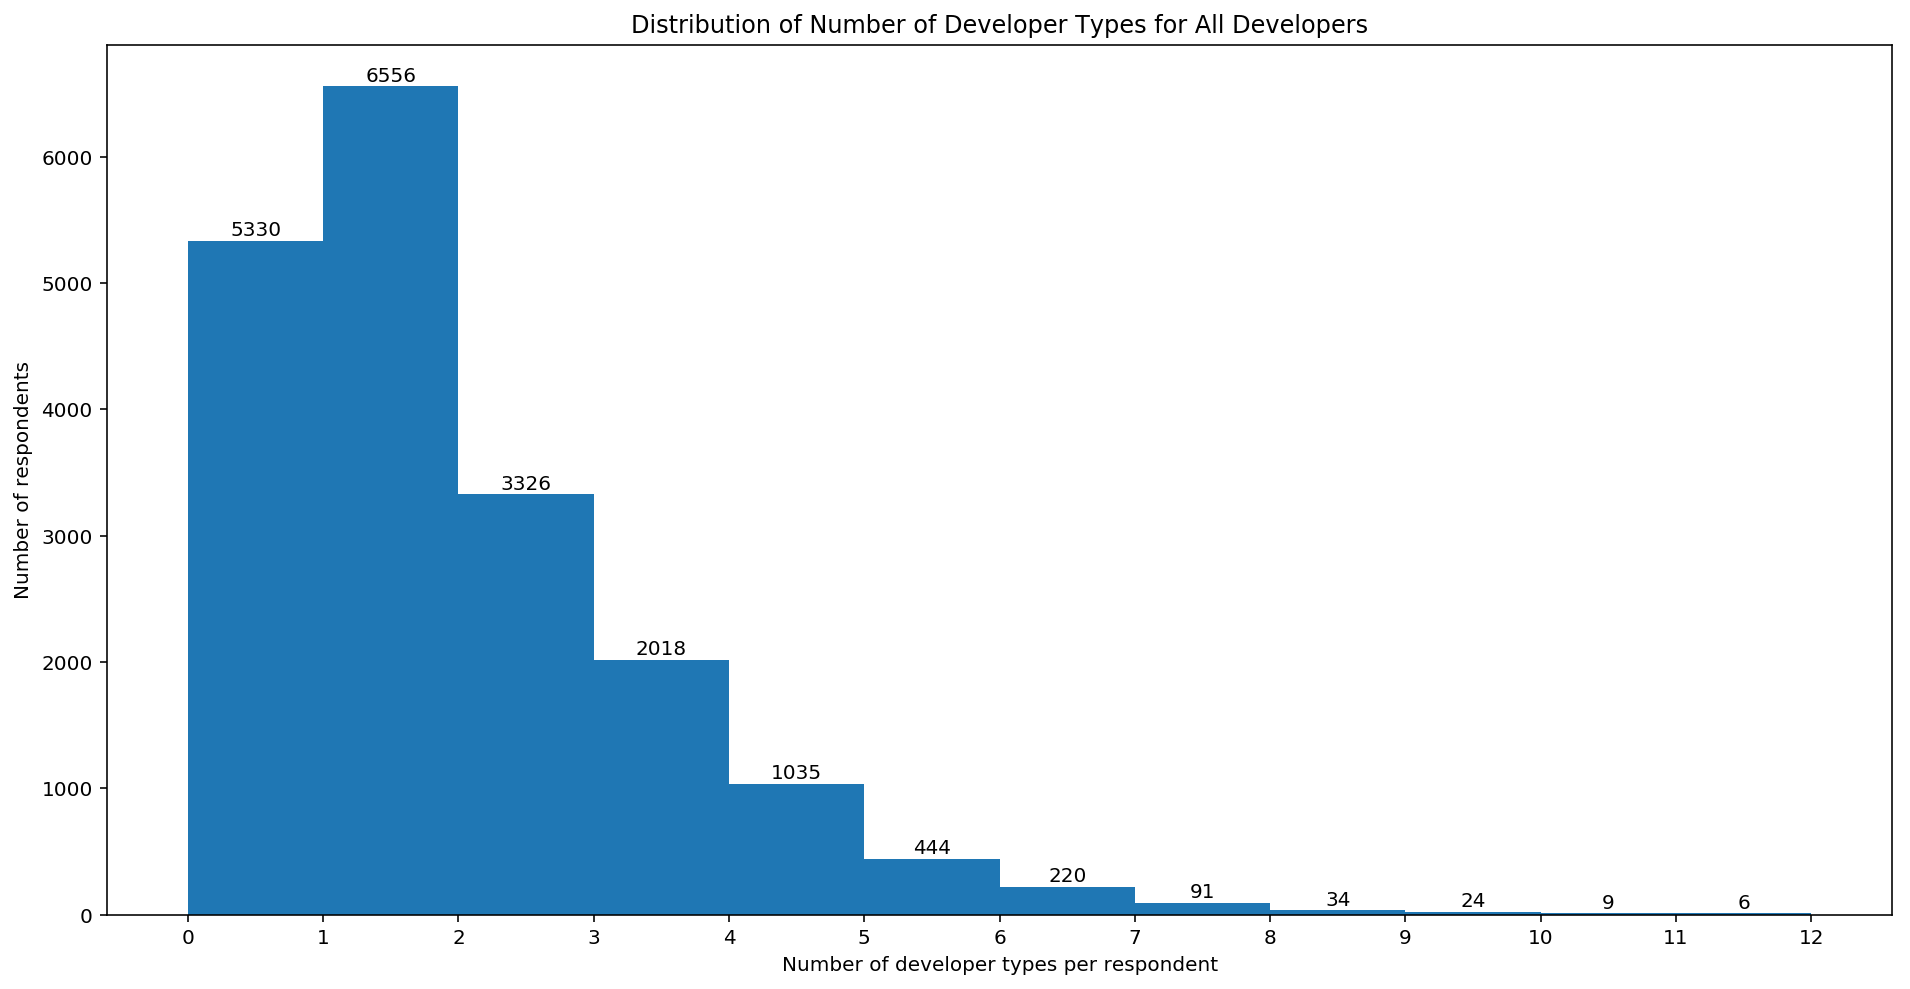

In [18]:
# Visualize the distribution of number of developer types per respondent
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(encoded_df['NumDevTypes'],bins=range(encoded_df['NumDevTypes'].max()))
ax.set_xticks(range(encoded_df['NumDevTypes'].max()))
ax.set_ylabel('Number of respondents')
ax.set_xlabel('Number of developer types per respondent')
ax.set_title('Distribution of Number of Developer Types for All Developers')

# Add value counts to histogram bars
rects = ax.patches
labels = encoded_df['NumDevTypes'].value_counts(sort=False)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, label,
            ha='center', va='bottom')
plt.show()

Again we see the 5330 missing responses in the histogram.  The most common number of developer types for a respondent is 1 (6556 respondents) with decreasing counts as the number of developer types increases up to 11.  Since the distribution is skewed to the right, the mean number of developer types (2.06) is greater than the mode (1).  I also want to look at this distribution for just the respondents who selected 'Data scientist' to see if those developers tended to include more or fewer developer types than the population as a whole.

In [19]:
# Create a dataframe that only includes respondents who selected 'Data scientist' as a developer type
ds_df = encoded_df.loc[encoded_df['Data scientist']==1,:]
# Drop all columns that are not developer types, and drop the 'Data scientist' column since it is all 1's
ds_df.drop(columns=['Salary','JobSatisfaction','NumDevTypes','Data scientist'],inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


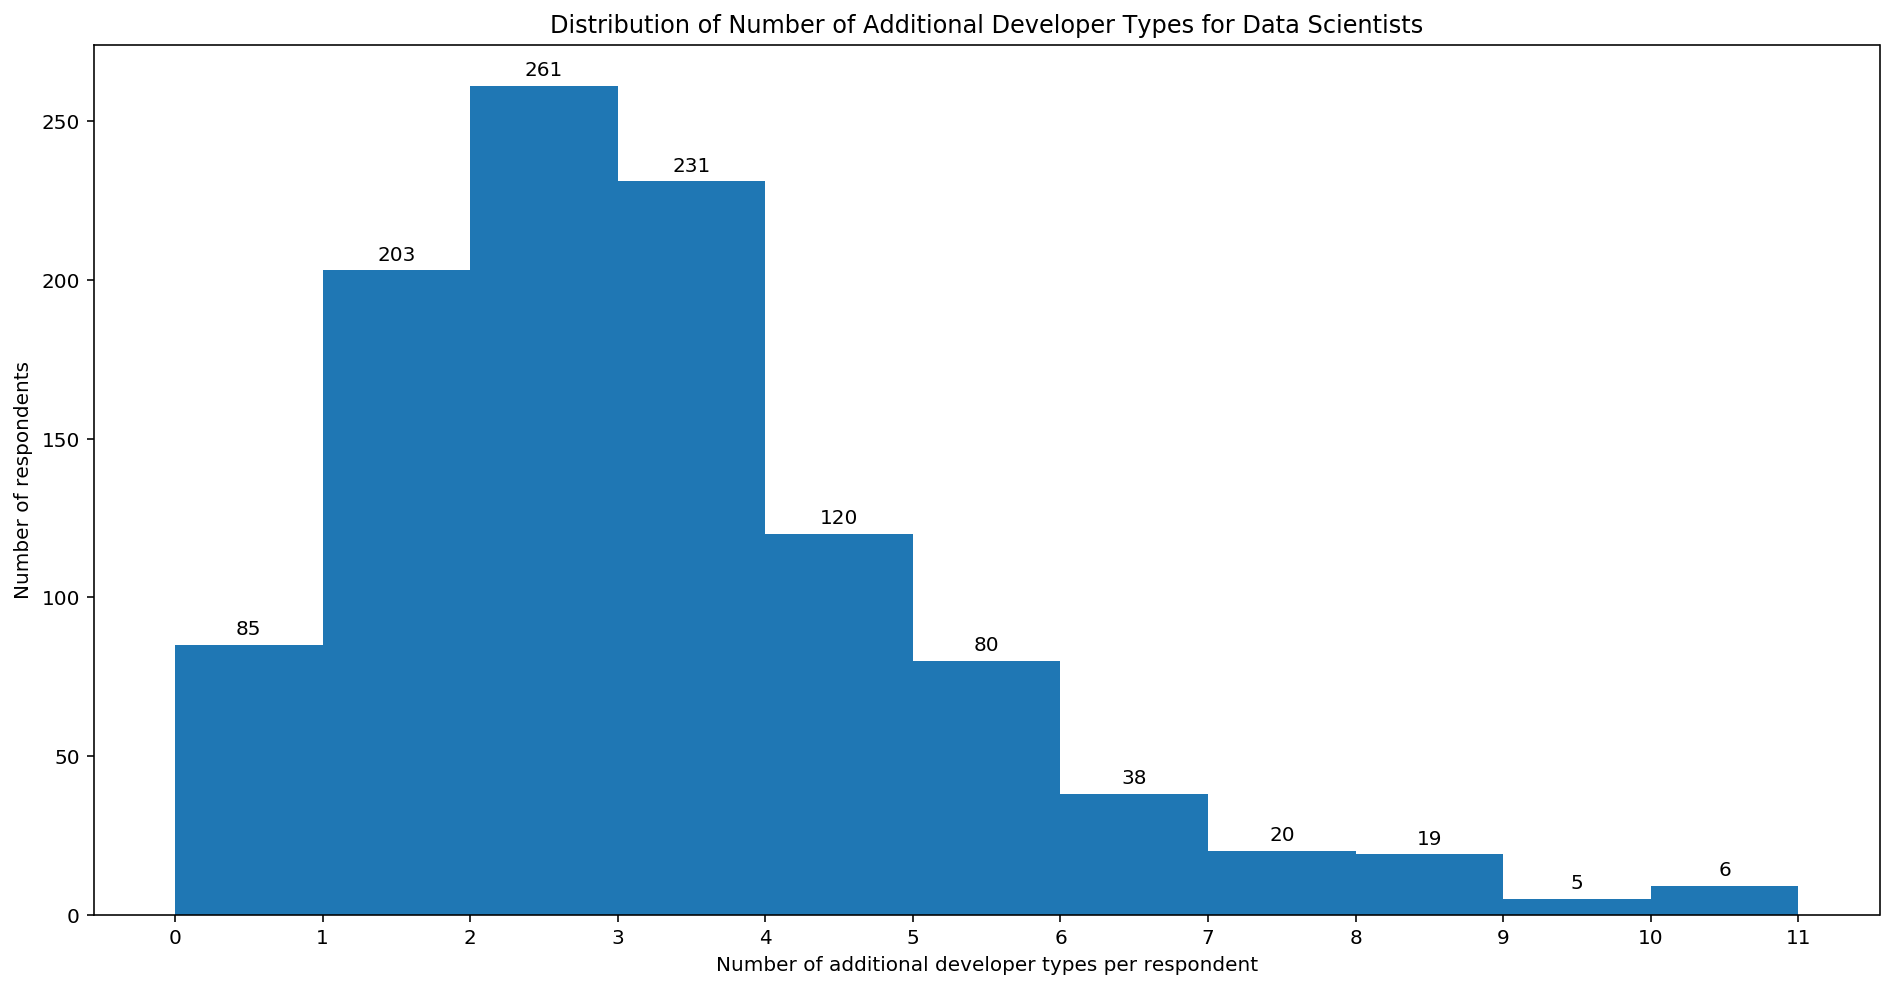

In [20]:
# Visualize the distribution of number of developer types per respondent for data scientists
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(ds_df.sum(axis=1),bins=range(ds_df.sum(axis=1).max()))
ax.set_xticks(range(ds_df.sum(axis=1).max()))
ax.set_ylabel('Number of respondents')
ax.set_xlabel('Number of additional developer types per respondent')
ax.set_title('Distribution of Number of Additional Developer Types for Data Scientists')

# Add value counts to histogram bars
rects = ax.patches
labels = ds_df.sum(axis=1).value_counts(sort=False)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 2, label,
            ha='center', va='bottom')
plt.show()

The distribution of number of developer types for data scientists is still skewed to the right, but it is centered at 2.  Considering that these respondents already selected one developer type - 'Data scientist' - this is an increase of 2 in the most common number of developer types per respondent for data scientists compared to all developers.  This tells me that 'data scientist' is not necessarily an 'exclusive' role that a developer focuses on solely.  I am curious which other developer types overlap with the role of data scientist.

In [21]:
# Calculate the frequency of each additional developer type for data scientists
ds_devtypes_df = pd.DataFrame(ds_df.mean(axis=0).sort_values(ascending=False),columns=['DS_Respondent_Freq'])
ds_devtypes_df

,DS_Respondent_Freq
Web developer,0.604457
Developer with a statistics or mathematics background,0.383473
Database administrator,0.310121
Desktop applications developer,0.308264
Machine learning specialist,0.277623
Mobile developer,0.191272
Systems administrator,0.175487
DevOps specialist,0.149489
Embedded applications/devices developer,0.132776
Graphics programming,0.080780


In [22]:
# Create a new dataframe by merging the dataframes capturing frequency of each developer type for all developers and for data scientists
merged_devtype_df = pd.merge(response_df_sorted, ds_devtypes_df, right_index=True, left_index=True)

# Calculate the difference in frequency for each developer type and sort
merged_devtype_df['Freq_Diff'] = merged_devtype_df['DS_Respondent_Freq']-merged_devtype_df['Respondent_Freq']
merged_devtype_df_sorted = merged_devtype_df.sort_values(by='Freq_Diff',ascending=False)
merged_devtype_df_sorted

,Count,Respondent_Freq,DS_Respondent_Freq,Freq_Diff
Developer with a statistics or mathematics background,1479,0.107392,0.383473,0.276081
Machine learning specialist,488,0.035434,0.277623,0.242189
Database administrator,1827,0.132660,0.310121,0.177460
Systems administrator,1479,0.107392,0.175487,0.068096
Embedded applications/devices developer,1174,0.085245,0.132776,0.047531
Quality assurance engineer,429,0.031150,0.074280,0.043130
DevOps specialist,1505,0.109280,0.149489,0.040210
Graphics programming,584,0.042405,0.080780,0.038375
Graphic designer,439,0.031876,0.061281,0.029405
Desktop applications developer,3869,0.280932,0.308264,0.027331


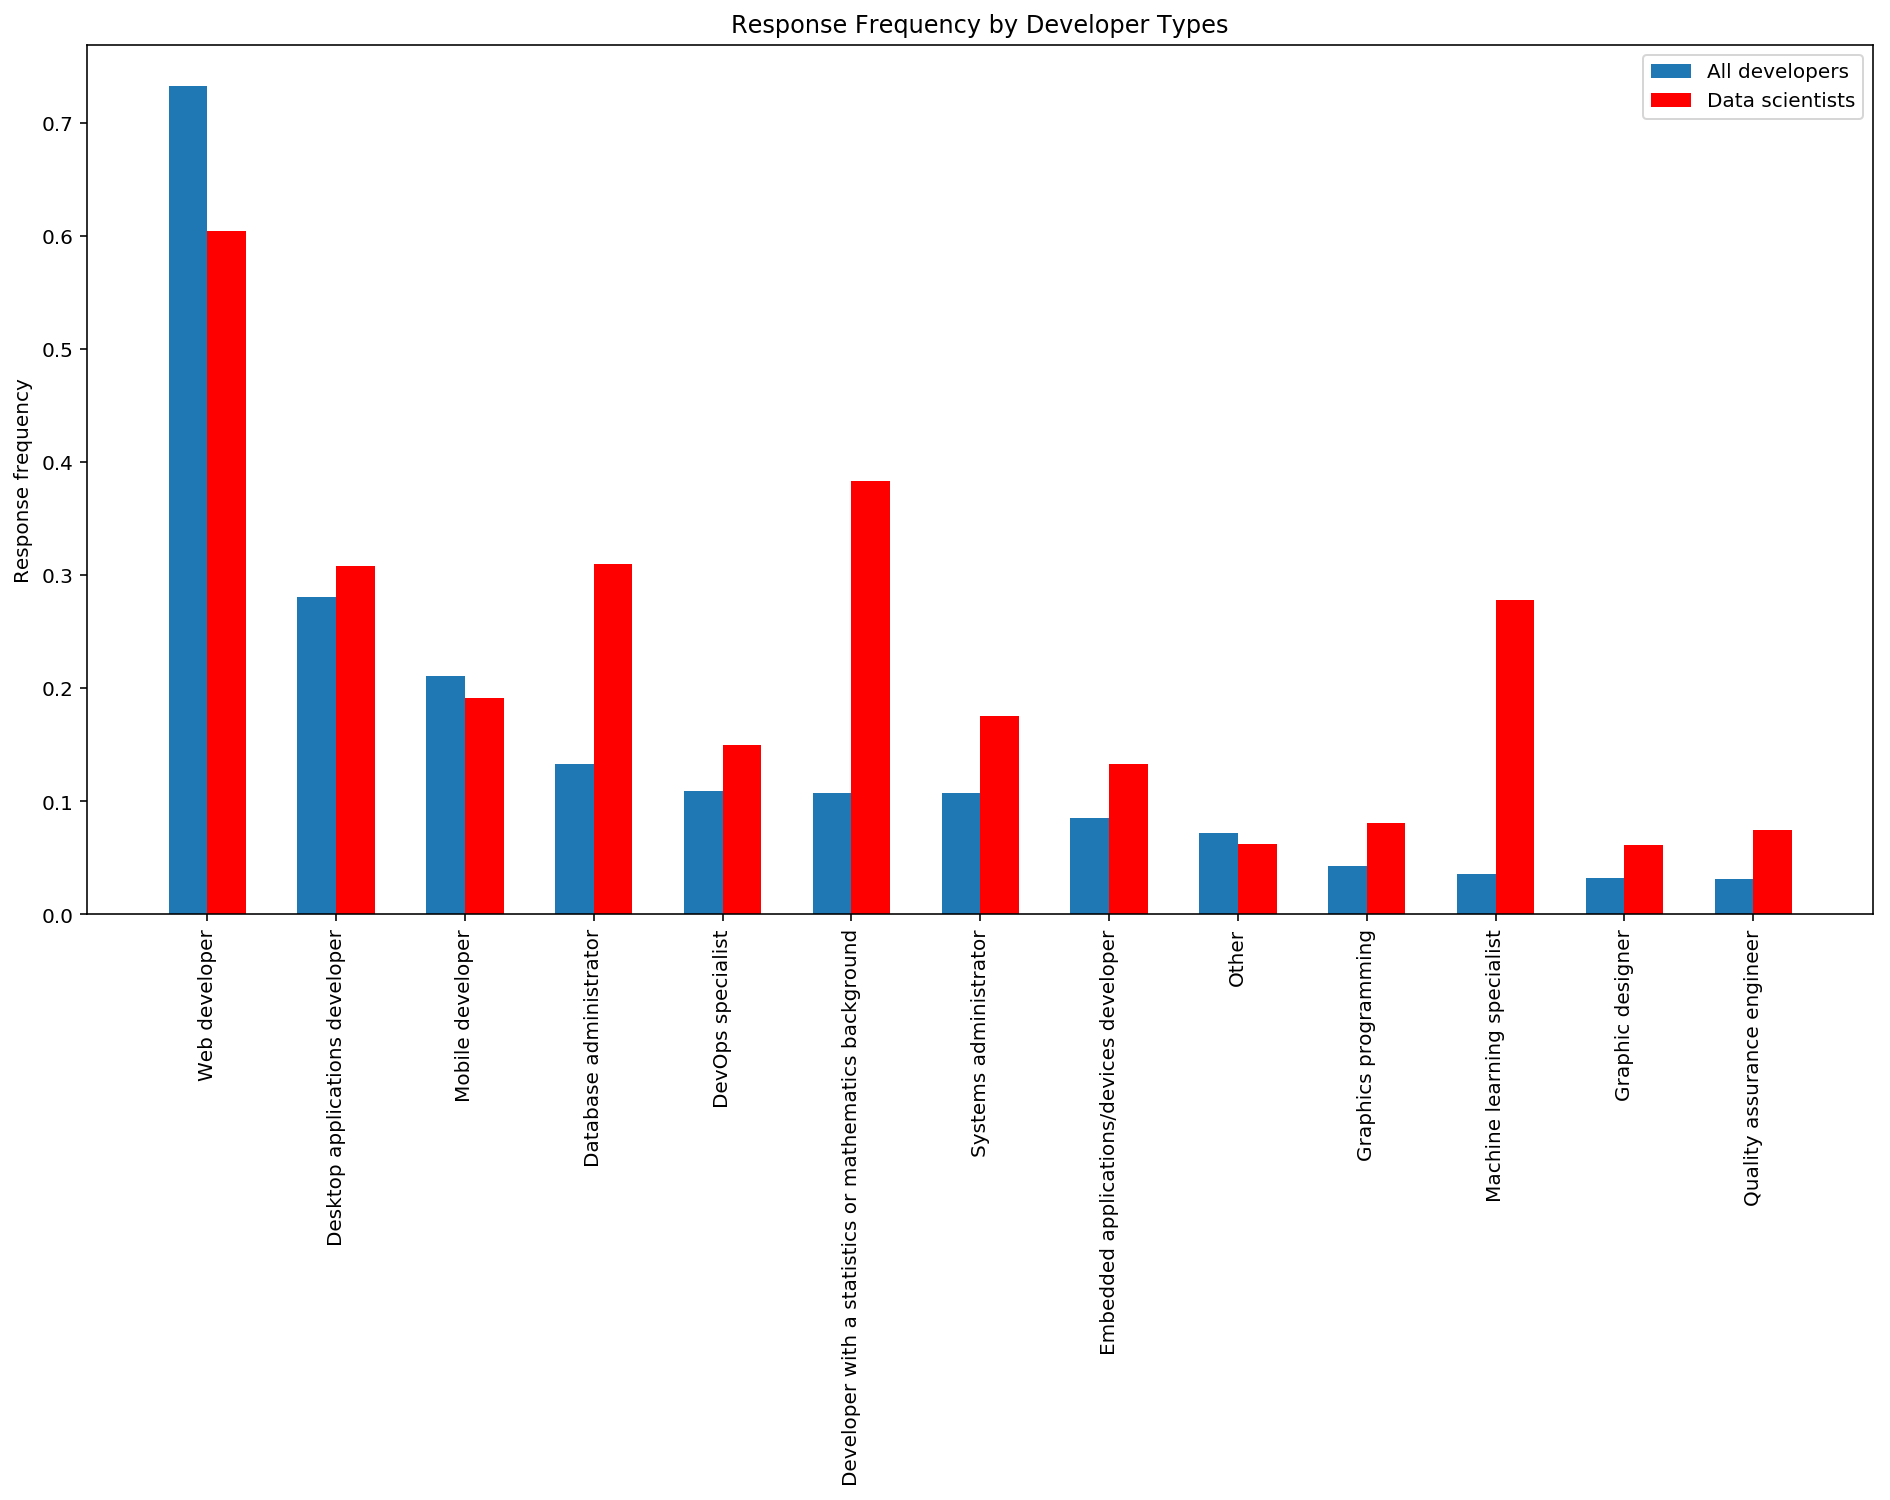

In [23]:
# Plot the developer type frequencies for all developers and for data scientists only
fig, ax = plt.subplots(figsize=(16,8))
ind = np.arange(len(merged_devtype_df.index))
width = 0.3
ax.bar(ind-width/2,merged_devtype_df['Respondent_Freq'], width=width)
ax.bar(ind+width/2, merged_devtype_df['DS_Respondent_Freq'],width=width, color='red')
ax.set_xticks(np.arange(len(merged_devtype_df.index)))
ax.set_xticklabels(merged_devtype_df.index,rotation=90)
ax.set_ylabel('Response frequency')
ax.set_title('Response Frequency by Developer Types')
ax.legend(['All developers','Data scientists'])
plt.show()

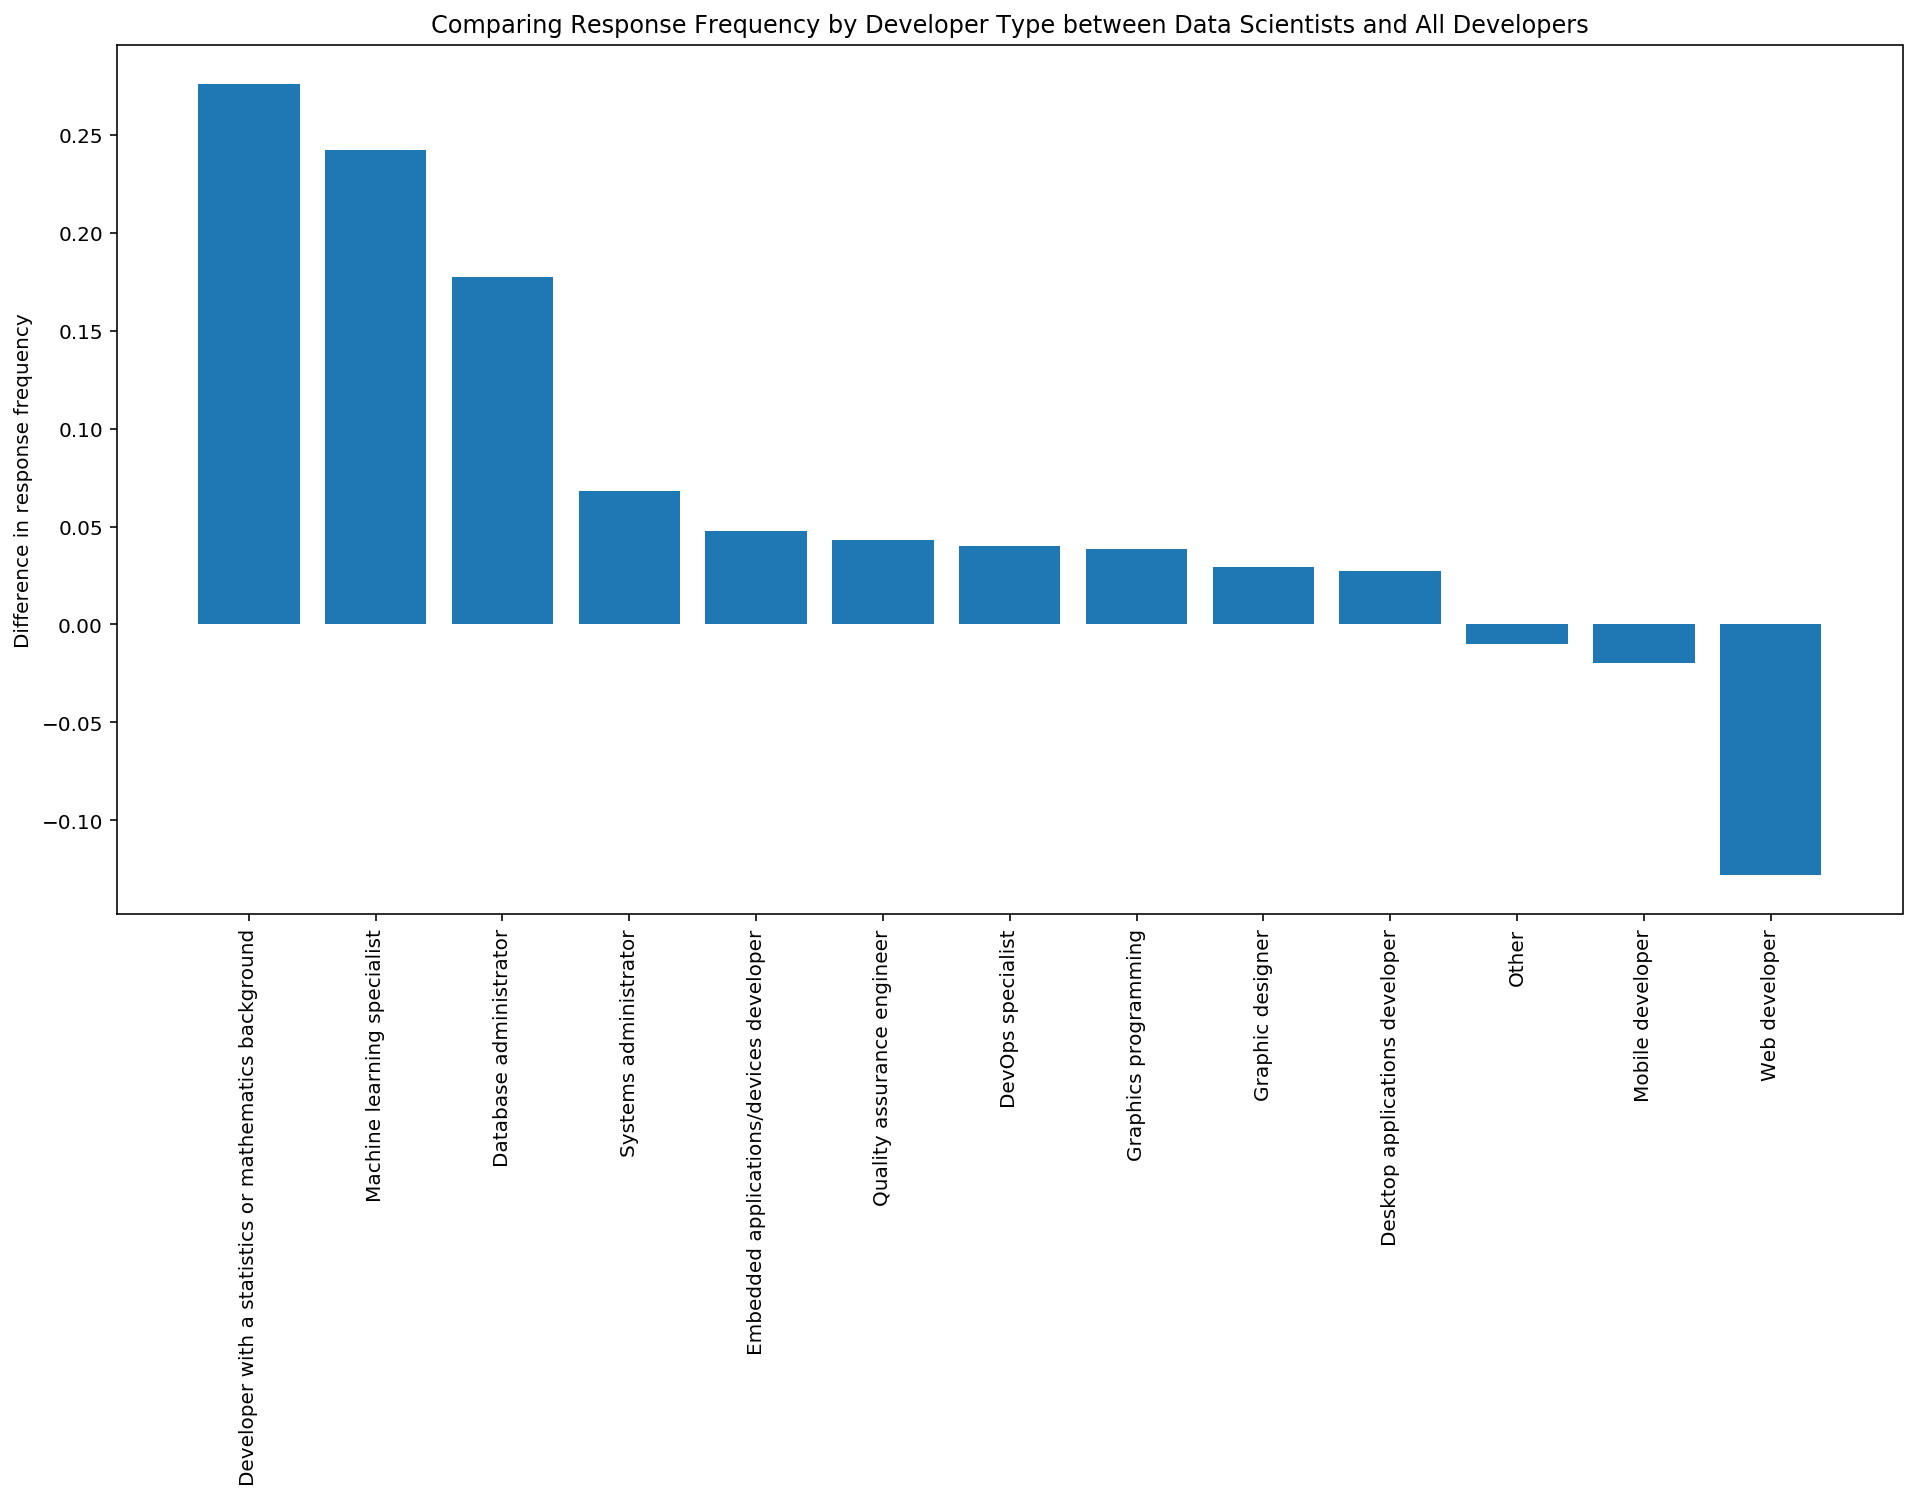

In [24]:
# Plot the differences in frequency of each developer type for data scientists vs all developers
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
ax1.bar(merged_devtype_df_sorted.index,merged_devtype_df_sorted['Freq_Diff'])
ax1.set_xticklabels(merged_devtype_df_sorted.index, rotation=90)
ax1.set_ylabel('Difference in response frequency')
ax1.set_title('Comparing Response Frequency by Developer Type between Data Scientists and All Developers')
plt.show()

There are some major differences in the frequencies of developer types when comparing all developers to just data scientists.  While 'web developer' is still the most frequent developer type for both groups, the frequency of overlap with data scientists is much lower (almost 13 percentage points) than for the general population.  Meanwhile, 'developer with a statistics or mathematics background' and 'machine learing specialist' are both more than 20 percentage points more likely to occur if a developer is a data scientist.  Neither of these trends surprises me too much, however, since a developer with a statistics or mathematics background could easily be a data analyst, and a machine learning specialist is a more specialized type of data scientist.  All three of these developer types are in the same family.

### Salary and Job Satisfaction
Now that I have a better sense of what developer types overlap with data scientists, I am curious how data scientists stack up in terms of salary and job satisfaction.  I will split the respondents into those that included 'Data scientist' in their survey response to those that did not and calculate the mean salary and job satisfaction for these groups.

In [25]:
# Compare mean salaries of respondents who included 'Data scientist' to those who did not
encoded_df.groupby('Data scientist')['Salary'].mean()

Data scientist
0    57811.470365
1    65572.904236
Name: Salary, dtype: float64

In [26]:
# Compare mean job satisfactions of respondents who included 'Data scientist' to those who did not
encoded_df.groupby('Data scientist')['JobSatisfaction'].mean()

Data scientist
0    6.976594
1    7.335283
Name: JobSatisfaction, dtype: float64

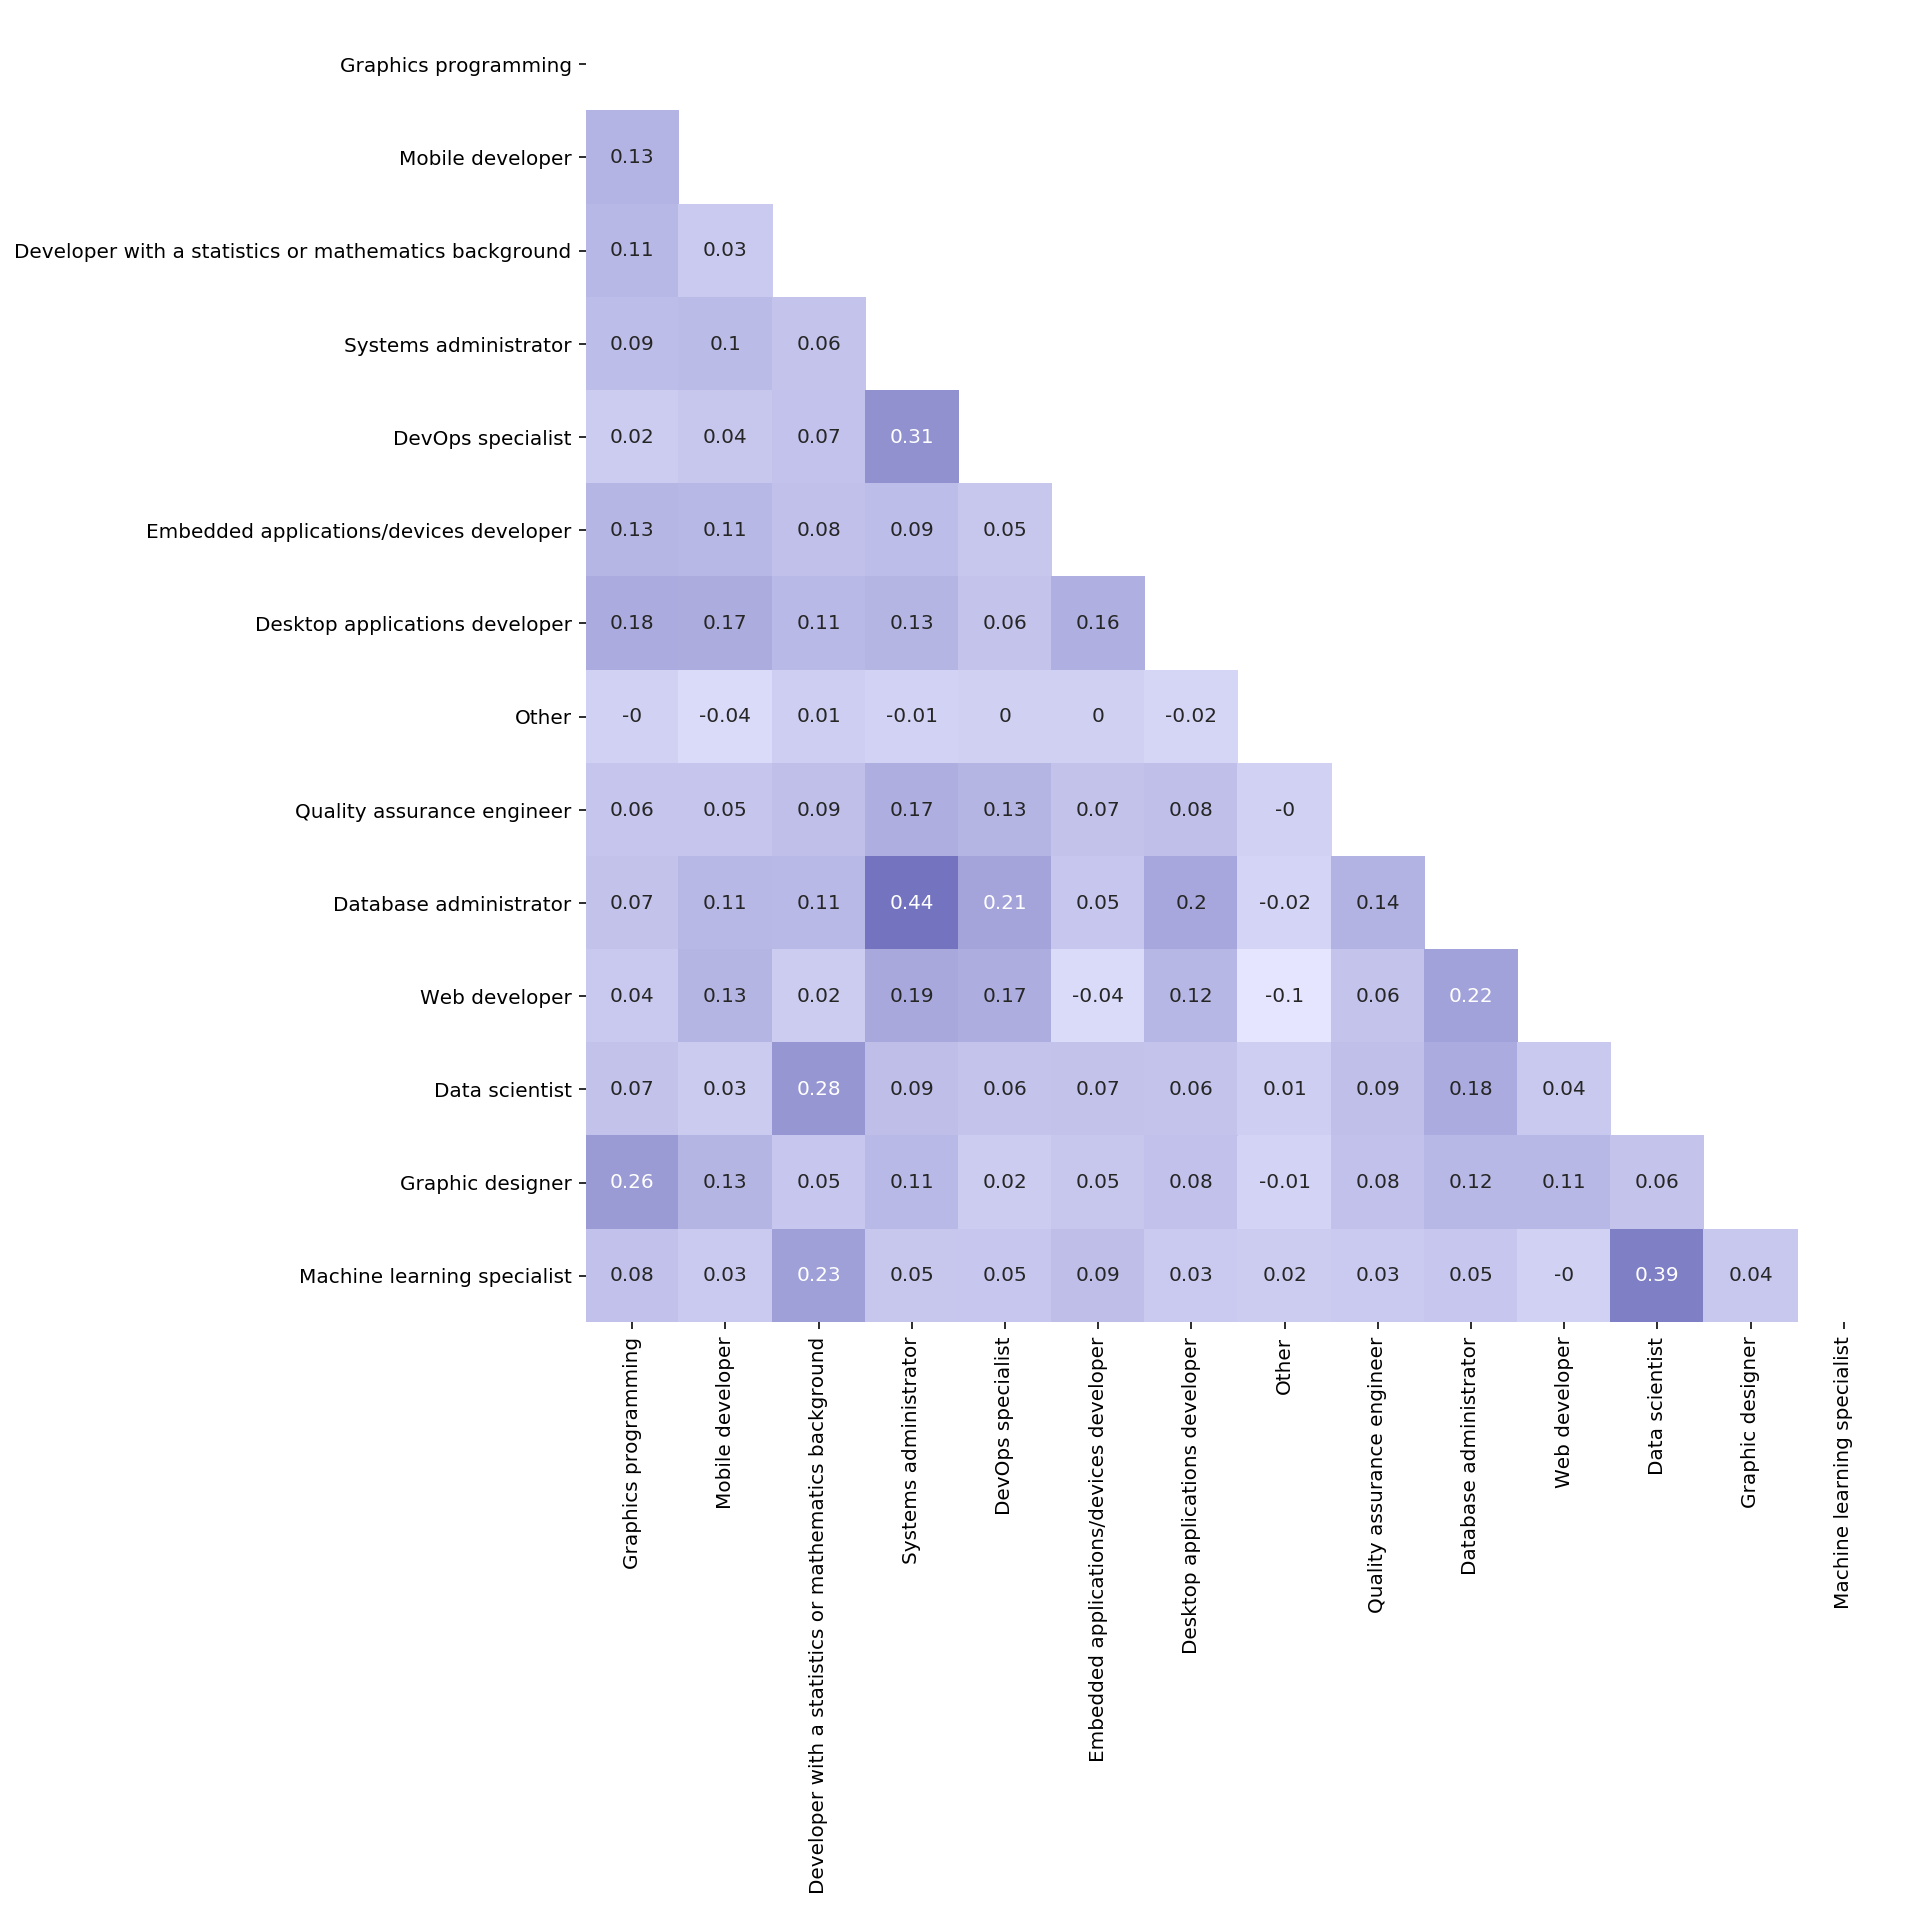

In [27]:
# Calculate correlations between the 14 DeveloperTypes
corr = encoded_df.iloc[:,-15:-1].corr()

# Visualize in a heat map
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.light_palette('navy',n_colors=5, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, mask=mask, cmap=cmap, annot=np.round(corr.values,2), square=True, cbar=False)

Performing some simple calculations on binary groupings (*i.e* data scientists vs not data scientists) gave me some good insights into how respondents answered this survey and I can begin to see the effect of data science on salary and job satisfaction.<br>
<br>
**Results:**
- The mean salary for respondents who included 'Data scientist' was over **13% higher** (\\$65,572 vs \\$57,811) than those who did not.
- The mean job satisfaction for data scientists was **5% higher** (7.33 vs 6.97).
- 'Data scientist' and 'Machine learning specialist' had the second highest correlation between any two developer types (1st was 'Database administrator' and 'Systems administrator').
- 'Data scientist' and 'Developer with a statistics or mathematics background' had the fourth highest correlation
  
**Takeaways:**
Respondents who are data scientists appear to have higher average salaries and job satisfaction ratings than other types of developers.  Once again, 'data scientist' is closely related to 'machine learning specialist' and 'developer with a statistics or mathematics background' as would be expected since they are all part of the data science realm.

### Education Recommendations
I am also interested in what advice data scientists have for breaking into their field.  To answer this, I will look at the 'CousinEducation' field.

In [28]:
# Look at the 'CousinEducation' question
print(schema.loc[schema['Column']=='CousinEducation','Question'].values)

["Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?\nLet's pretend you have a distant cousin named Robert. He is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. He wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Robert?\nLet's pretend you have a distant cousin named Alice. She is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. She wants your advice on how to switch to a career as a software developer. Which

In [29]:
# Create a new dataframe with only the features I am interested in - DeveloperType and CousinEducation
education_df = df[['DeveloperType','CousinEducation']]

# Visualize the first 20 rows
education_df.head(20)

,DeveloperType,CousinEducation
0,NaN,NaN
1,NaN,NaN
2,Other,NaN
3,NaN,NaN
4,Mobile developer; Graphics programming; Deskto...,NaN
5,NaN,NaN
6,NaN,NaN
7,Web developer,Get a job as a QA tester
8,Web developer; Mobile developer,NaN
9,Mobile developer; Desktop applications developer,NaN


There are a lot of null values in the 'CousinEducation' column.  I will drop these missing values from the column since it is effectively my response feature in this exercise.  Before I do that, however, I first want to look at the null values in the 'DeveloperType' column and see if those rows correspond to non-null values in the 'CousinEducation' column.  There are also multiple responses within each row.  I will use the generate_onehot function I created earlier to parse out all of the responses.

In [30]:
# Count number of rows that are missing values for both 'DeveloperType' and 'CousinEducation'
education_df.loc[education_df['DeveloperType'].isnull(),'CousinEducation'].isnull().sum()

3586

Of the 5330 rows with missing values for 'DeveloperType', 3586 also have missing values for 'CousinEducation'. I will fill the remaining rows with the most common developer type - 'Web developer'.

In [31]:
# Fill 'NaN's in 'DevloperType' with 'Web developer'
education_df.fillna({'DeveloperType':'Web developer'},inplace=True)

# Drop missing values from 'CousinEducation' and reset index in preparation of calling generate_onehot function
education_df.dropna(inplace=True)
education_df.reset_index(inplace=True,drop=True)

# Call generate_onehot function on both columns
encoded_education_df = generate_onehot(education_df, 'DeveloperType','; ')
encoded_education_df = generate_onehot(encoded_education_df, 'CousinEducation','; ')

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [32]:
# Visualize first 5 rows to confirm successful encoding
encoded_education_df.head()

,Graphics programming,Mobile developer,Developer with a statistics or mathematics background,Systems administrator,DevOps specialist,Embedded applications/devices developer,Desktop applications developer,Other,Quality assurance engineer,Database administrator,...,None of these,Participate in hackathons,Contribute to open source,Participate in online coding competitions,Conferences/meet-ups,Bootcamp,Return to college,Get a job as a QA tester,Buy books and work through the exercises,Part-time/evening courses
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [33]:
# Create dataframe of frequencies of each education type recommended by all developers
dev_ed_recs_df = pd.DataFrame(encoded_education_df.iloc[:,14:].mean(axis=0).sort_values(ascending=False),columns=['Ed_Freq'])
dev_ed_recs_df

,Ed_Freq
Take online courses,0.642919
Buy books and work through the exercises,0.495511
Contribute to open source,0.335650
Part-time/evening courses,0.315812
Bootcamp,0.227194
Conferences/meet-ups,0.222705
Return to college,0.212714
Get a job as a QA tester,0.150014
Participate in online coding competitions,0.144657
Master's degree,0.111787


In [34]:
# Create a dataframe only containing recommendations from data scientists
ds_education_df = encoded_education_df.loc[encoded_education_df['Data scientist'] ==1,:]

# Create a dataframe of frequencies of each education type recommended by data scientists
ds_ed_recs_df = pd.DataFrame(ds_education_df.iloc[:,14:].mean(axis=0).sort_values(ascending=False),columns=['DS_Ed_Freq'])
ds_ed_recs_df

,DS_Ed_Freq
Take online courses,0.613514
Buy books and work through the exercises,0.451351
Contribute to open source,0.351351
Part-time/evening courses,0.310811
Participate in online coding competitions,0.216216
Conferences/meet-ups,0.197297
Return to college,0.191892
Bootcamp,0.183784
Participate in hackathons,0.154054
Get a job as a QA tester,0.145946


In [35]:
# Create a new dataframe by merging the dataframes capturing frequency of each education recommended by all developers and by data scientists
merged_ed_recs_df = pd.merge(dev_ed_recs_df, ds_ed_recs_df, right_index=True, left_index=True)

# Calculate the difference in frequency for each education type and sort
merged_ed_recs_df['Freq_Diff'] = merged_ed_recs_df['DS_Ed_Freq']-merged_ed_recs_df['Ed_Freq']
merged_ed_recs_df_sorted = merged_ed_recs_df.sort_values(by='Freq_Diff',ascending=False)
merged_ed_recs_df_sorted

,Ed_Freq,DS_Ed_Freq,Freq_Diff
Participate in online coding competitions,0.144657,0.216216,0.071559
Participate in hackathons,0.107588,0.154054,0.046466
Master's degree,0.111787,0.143243,0.031456
Contribute to open source,0.335650,0.351351,0.015701
None of these,0.026209,0.029730,0.003521
Get a job as a QA tester,0.150014,0.145946,-0.004069
Part-time/evening courses,0.315812,0.310811,-0.005002
Return to college,0.212714,0.191892,-0.020822
Conferences/meet-ups,0.222705,0.197297,-0.025408
Take online courses,0.642919,0.613514,-0.029406


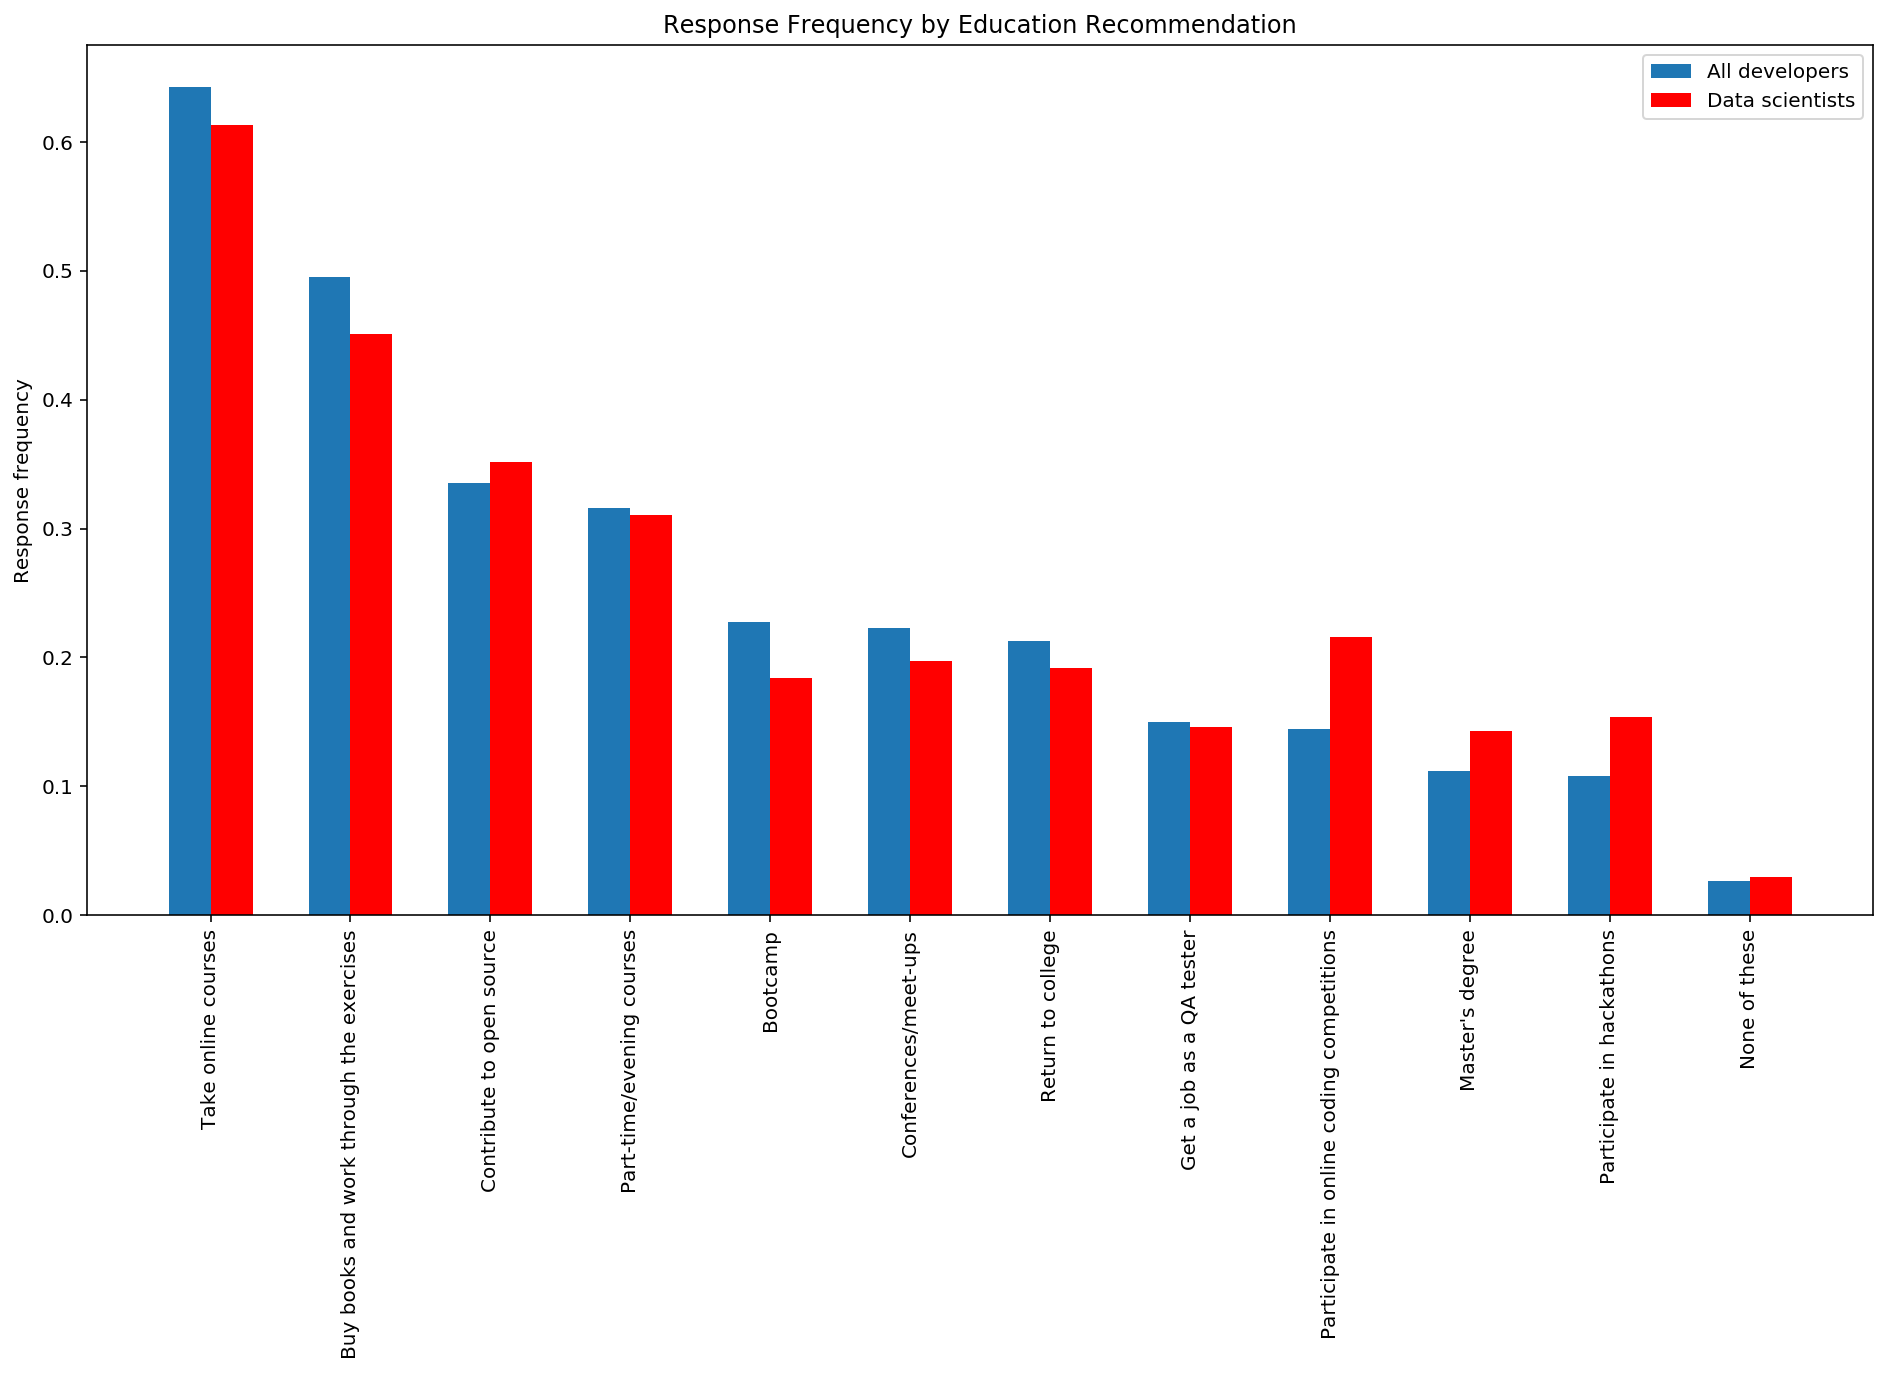

In [36]:
# Plot the education recommendation frequencies by all developers and by data scientists
fig, ax = plt.subplots(figsize=(16,8))
ind = np.arange(len(merged_ed_recs_df_sorted.index))
width = 0.3
ax.bar(ind-width/2,merged_ed_recs_df['Ed_Freq'], width=width)
ax.bar(ind+width/2, merged_ed_recs_df['DS_Ed_Freq'],width=width, color='red')
ax.set_xticks(np.arange(len(merged_ed_recs_df.index)))
ax.set_xticklabels(merged_ed_recs_df.index,rotation=90)
ax.set_ylabel('Response frequency')
ax.set_title('Response Frequency by Education Recommendation')
ax.legend(['All developers','Data scientists'])
plt.show()

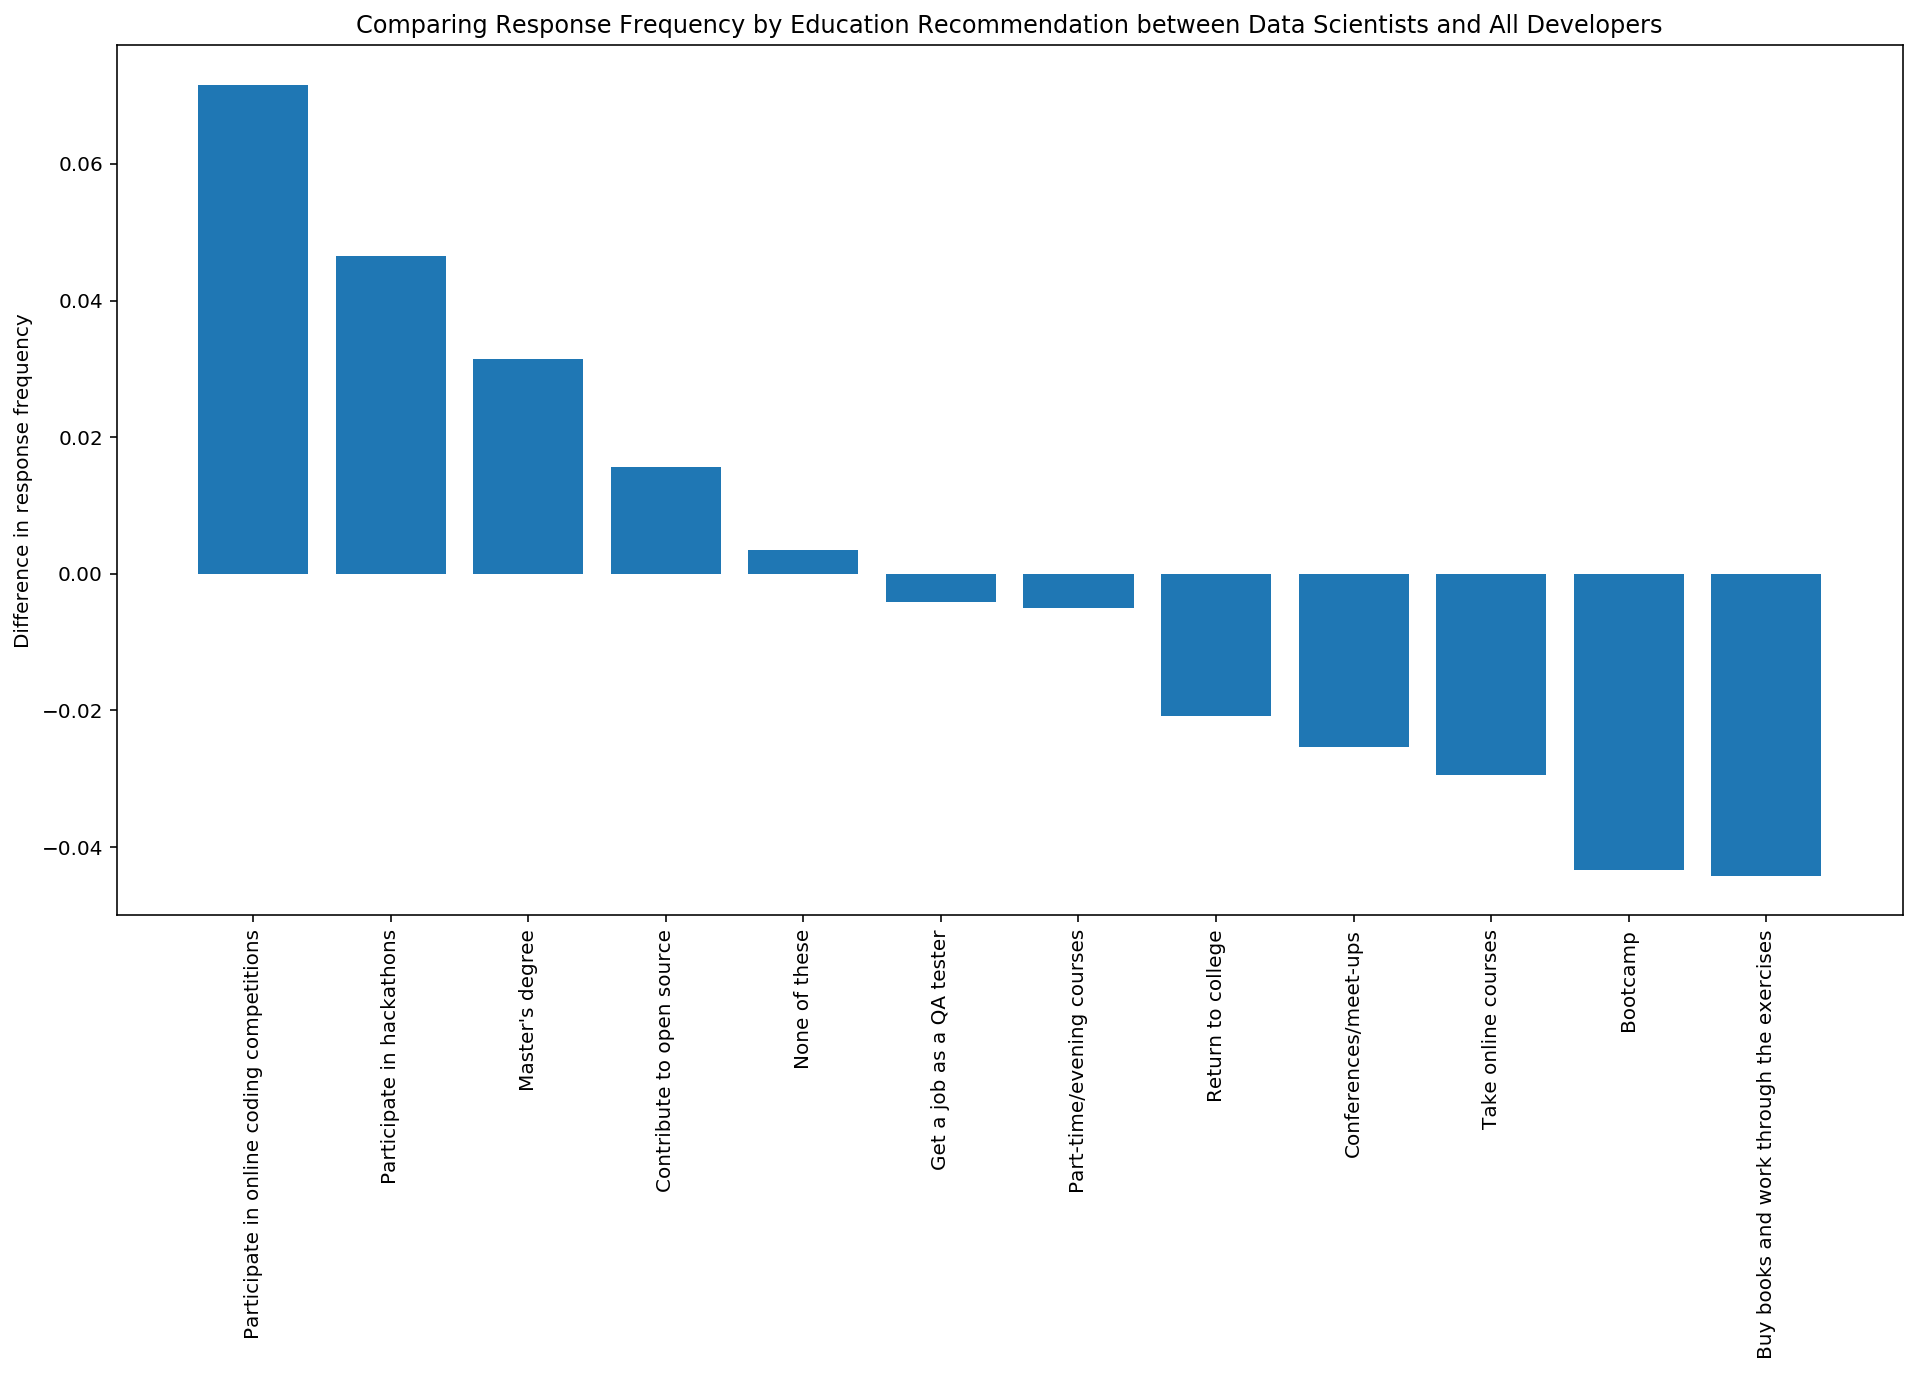

In [37]:
# Plot the differences in frequency of each education recommendation by data scientists vs all developers
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
ax1.bar(merged_ed_recs_df_sorted.index, merged_ed_recs_df_sorted['Freq_Diff'])
ax1.set_xticklabels(merged_ed_recs_df_sorted.index, rotation=90)
ax1.set_ylabel('Difference in response frequency')
ax1.set_title('Comparing Response Frequency by Education Recommendation between Data Scientists and All Developers')
plt.show()

The education types recommended by data scientists are pretty similiar to those recommended by all developers.  That tells me that taking online courses, working through book exercises, contributing to open sources, and participating in bootcamps are all good ways to break into industry.  The biggest differences in education types recommended by data scientists are participating in online coding competitions and hackathons.  These two activities are very similar - online coding competitions can be considered a form of online hackathon - so it makes sense that these two recommendations are grouped together.  The fact that these reflect the biggest gap between data scientists and developers makes me think of Kaggle, which is a very popular source for online data science competitions.  Udacity has also partnered with AWS to launch a deep learning competition centered around autonomous race cars.  The popularity of online coding competitions aligns well with this recommendation.

### Modeling

To really separate the effect of being a data scientist on salary, I need to do more than just compare two different developer types.  Looking at the mean salary of data scientists and comparing it to the mean salary of those who are not data scientists does not account for all of the other potential developer types or other hidden variables.  For example, perhaps data scientists are more common in the United States, where salaries are higher; or they are considered senior developers, so their salaries are higher due to more years in the industry.  A better way to do this would be to create a linear models to predict salary and job satisfaction and look at the feature weights to see which developer type has the biggest impact on each.  I will use scikit-learn's *LinearRegression* package to create these models.

In [38]:
# Create a new dataframe with only the features I am interested in - DeveloperType and Salary
model_df = df[['DeveloperType','Salary']]

In [39]:
# Visualize first 5 rows
model_df.head()

,DeveloperType,Salary
0,NaN,NaN
1,NaN,NaN
2,Other,113750.0
3,NaN,NaN
4,Mobile developer; Graphics programming; Deskto...,NaN


I need to handle the 'NaN's in each column.  The 'Salary' column in my response variable.  I will drop all missing values from this column since I can't compare predicted values to missing values.  For the 'DeveloperType' column, this is my input variable into a model.  I could drop the rows with 'NaN' or keep them and impute a value into those rows.  Before deciding, I am curious whether there are Salary values reported by respondents who didn't answer the developer type question.

In [40]:
# Generate the onehot encoded dataframe for 'DeveloperType'
encoded_model_df = generate_onehot(model_df,'DeveloperType','; ')

In [41]:
# Look at descriptive stats for Salary for missing values for 'DeveloperType'
encoded_model_df.loc[encoded_model_df['nan']==1][['Salary']].describe()

,Salary
count,1.0
mean,125000.0
std,NaN
min,125000.0
25%,125000.0
50%,125000.0
75%,125000.0
max,125000.0


There appears to be one respondent who provided a (rather high) salary without reporting a developer type.  I am comfortable dropping this one data point from the model for predicting salary.

In [42]:
# Drop missing values from the response variables 'Salary'
encoded_model_df.dropna(inplace=True)

In [43]:
# Write a function to split the dataset into X and y, train and test, instantiate, fit, predict, and score a Linear Regression model
def generate_model(df, output, test_size = 0.3, rand_state = 42):
    '''
    Generate a linear regression model by specifying a dataset and the output column
    
    df: pandas DataFrame, should be cleaned already and include the output column
    output: string, the name of the column in df that is the output variable
    test_size: float (default=0.3), the fraction of the dataset, df, that is dedicated to testing
    rand_state: int (default=42), the random state number for reproducible results
    
    returns:
    X_train, X_test, y_train, y_test, model, train_score, test_score
    '''
    # Split the dataset, df, into X (input matrix) and y (response vector)
    X = df.drop(columns=output)
    y = df[output]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = rand_state, shuffle=True)
    
    # Instantiate linear regression model
    model = LinearRegression(normalize=False) # Note, since X is onehot encoded, I will not normalize
    
    # Fit model to train data
    model.fit(X_train, y_train)
    
    # Predict training and testing values
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    # Score the training and testing sets
    train_score = r2_score(y_train, y_train_preds)
    test_score = r2_score(y_test, y_test_preds)
    
    return X_train, X_test, y_train, y_test, model, train_score, test_score

In [44]:
# Call generate_model function on the dataset
X_train, X_test, y_train, y_test, model, train_score, test_score = generate_model(encoded_model_df, 'Salary')

print('Training score:',train_score)
print('Testing score:',test_score)

Training score: 0.03716182180043448
Testing score: 0.03148784988245712


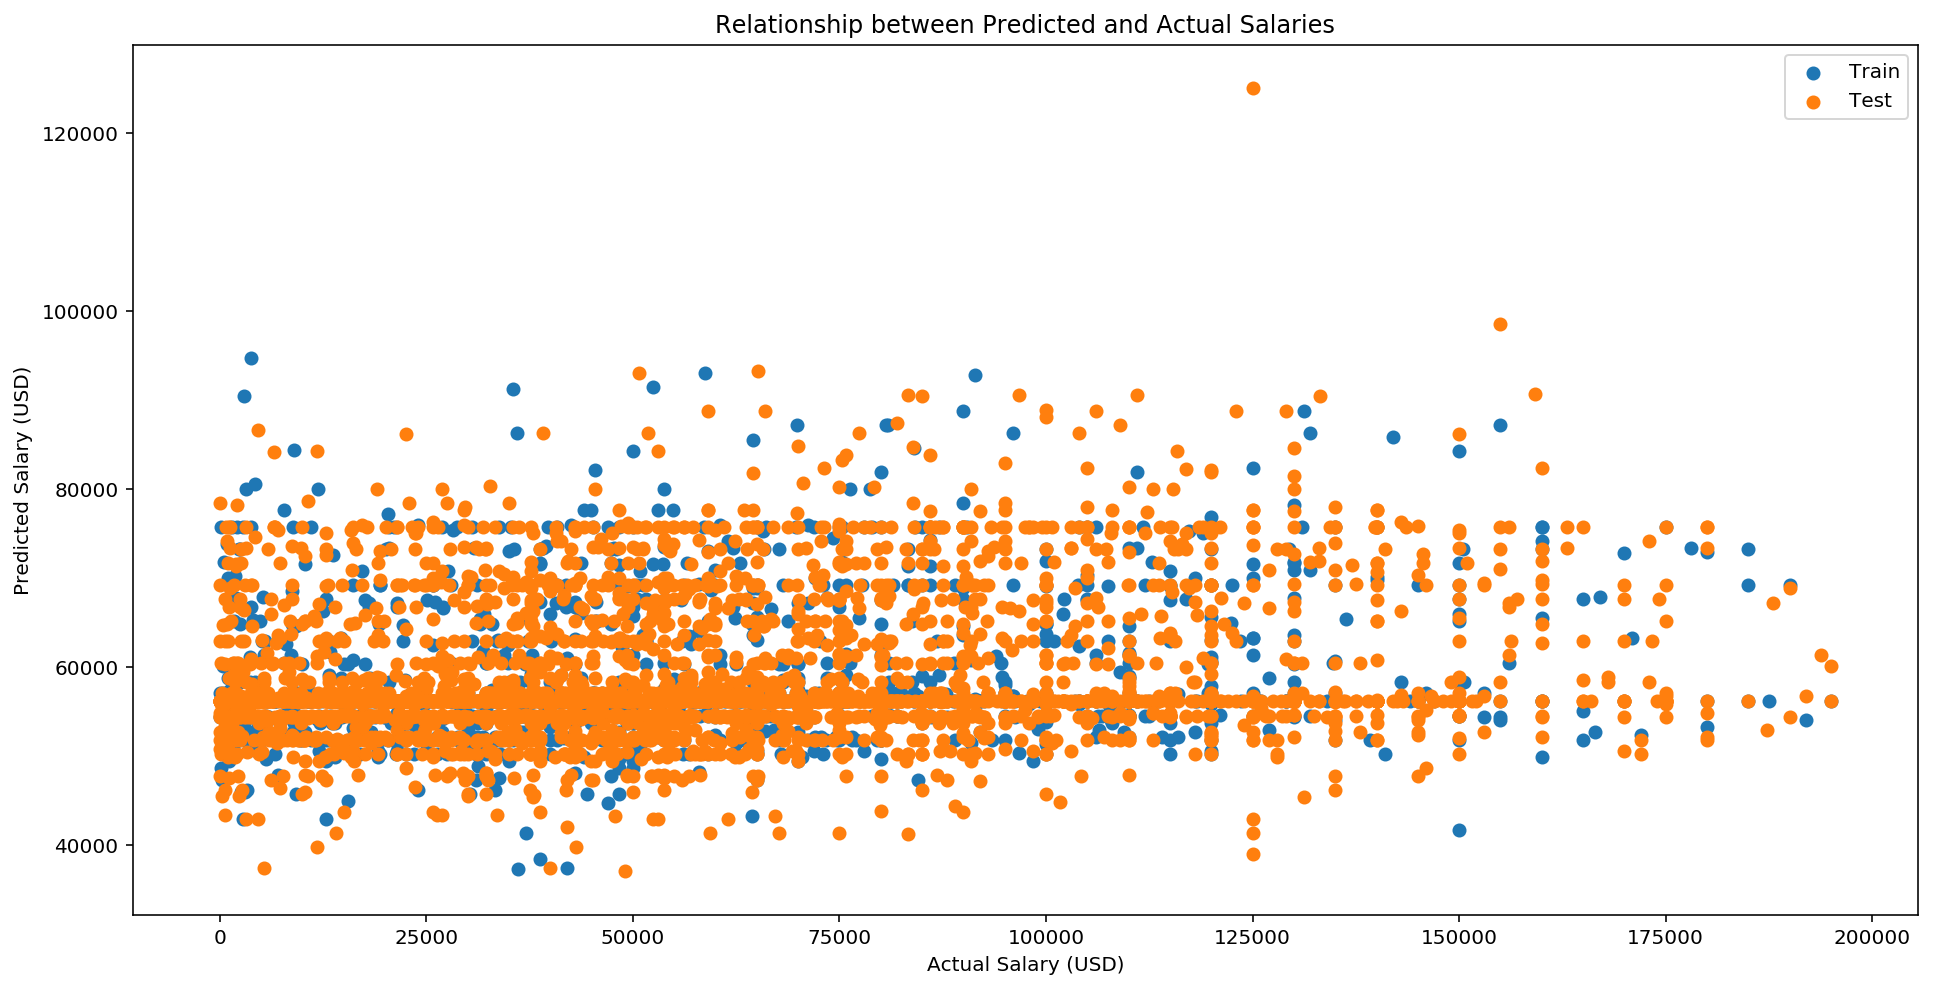

In [45]:
# Visualize the relationship between predicted and actual salaries for the test and training sets
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(y_test, model.predict(X_test))
ax.scatter(y_train, model.predict(X_train))
ax.legend(['Train','Test'])
ax.set_xlabel('Actual Salary (USD)')
ax.set_ylabel('Predicted Salary (USD)')
ax.set_title('Relationship between Predicted and Actual Salaries')
plt.show()

The model did not have a very high $r^2$ value for either the training or testing data sets.  The predicted salaries only ranged from about \\$40,000 to \\$100,000 whereas the actual salaries ranged from \\$0 to \\$200,000.  These scores tell me that developer type by itself is not a strong enough feature to predict salary.  Thinking back to a previous study that I performed on the Stack Overflow survey data for a class, 'Country' and 'YearsCodedJob' were the two features most strongly related to salary.  I will build a new model with these additional features and see if I can obtain a better fit.  Once I have a model that performs reasonably well I can look at the contributions that the developer types have on the salary predictions.

In [46]:
# Create a new dataframe with 'Country' and 'YearsCodedJob' features in added
model2_df = df[['Country','YearsCodedJob','DeveloperType','Salary']]

In [47]:
# Check the number of null values in each feature
model2_df.isnull().sum(axis=0)

Country              0
YearsCodedJob     3711
DeveloperType     5330
Salary           14093
dtype: int64

There are no missing values in the 'Country' feature but there are 3711 in the 'YearsCodedJob' feature.  Since this feature is categorical, I will fill the missing values with the most common value (mode).

In [48]:
# Fill missing values in 'YearsCodedJob' with the mode
model2_df = model2_df.fillna({'YearsCodedJob':model2_df['YearsCodedJob'].mode()[0]})

In [49]:
# Check that missing values have been removed from the input features
model2_df.isnull().sum(axis=0)

Country              0
YearsCodedJob        0
DeveloperType     5330
Salary           14093
dtype: int64

In [50]:
# Drop missing values from the remaining variables: 'DeveloperType' and 'Salary'
model2_df.dropna(inplace=True)

In [51]:
# Perform onehot encoding on the 'Country' and 'YearsCodedJob' categorical features
encoded_model2_df = pd.get_dummies(model2_df,columns=['Country','YearsCodedJob'])

# Reset the indices after splitting (necessary for the generate_onehot function below)
encoded_model2_df.reset_index(inplace=True, drop=True)
encoded_model2_df.head()

,DeveloperType,Salary,Country_Afghanistan,Country_Albania,Country_Argentina,Country_Armenia,Country_Australia,Country_Austria,Country_Azerbaidjan,Country_Bangladesh,...,YearsCodedJob_2 to 3 years,YearsCodedJob_20 or more years,YearsCodedJob_3 to 4 years,YearsCodedJob_4 to 5 years,YearsCodedJob_5 to 6 years,YearsCodedJob_6 to 7 years,YearsCodedJob_7 to 8 years,YearsCodedJob_8 to 9 years,YearsCodedJob_9 to 10 years,YearsCodedJob_Less than a year
0,Other,113750.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Embedded applications/devices developer,100000.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Web developer; Embedded applications/devices d...,130000.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Web developer,82500.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Other,100764.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [52]:
# Generate the onehot encoded dataframe for 'DeveloperType'
encoded_model2_df = generate_onehot(encoded_model2_df,'DeveloperType','; ')

# Check shape of dataframe prior to modeling
encoded_model2_df.shape

(5008, 143)

There are only 5008 rows in the dataset due to the large number of missing salaries from the survey results.  Meanwhile, there are 143 features in the dataset due to the onehot encoding of the categorical features.  I am guessing that most of these features are countries and that not all of them are necessary for the model.  I will check what the mean value of each feature is to see the frequency of occurrence in the dataset.

In [53]:
# Calculate mean of each feature and sort from highest to lowest
encoded_model2_df.mean(axis=0).sort_values(ascending=False)

Salary                                                   58328.088147
Web developer                                                0.732628
Country_United States                                        0.293930
Desktop applications developer                               0.276158
Mobile developer                                             0.195288
Database administrator                                       0.127796
DevOps specialist                                            0.119209
YearsCodedJob_2 to 3 years                                   0.113419
YearsCodedJob_1 to 2 years                                   0.107628
Systems administrator                                        0.103834
Developer with a statistics or mathematics background        0.103235
YearsCodedJob_3 to 4 years                                   0.097244
Country_United Kingdom                                       0.094449
YearsCodedJob_4 to 5 years                                   0.088059
YearsCodedJob_5 to 6

As I suspected, quite a few country features have very low frequencies in the dataset, with the lowest only occuring in 0.02% of rows.  In a dataset with 5008 rows, 0.02% means there is exactly 1 row in which a respondent selected that country.  These features will not help the model since they do not actually contain much information in them.  To determine how many of these low frequency features to drop, I will look at the frequencies of the 14 developer types and drop any columns with lower frequencies.

In [54]:
# Calculate mean of each of the 14 developer type features and sort from highest to lowest
encoded_model2_df.iloc[:,-14:].mean(axis=0).sort_values(ascending=False)

Web developer                                            0.732628
Desktop applications developer                           0.276158
Mobile developer                                         0.195288
Database administrator                                   0.127796
DevOps specialist                                        0.119209
Systems administrator                                    0.103834
Developer with a statistics or mathematics background    0.103235
Embedded applications/devices developer                  0.080272
Other                                                    0.080072
Data scientist                                           0.068291
Graphics programming                                     0.035543
Quality assurance engineer                               0.032748
Machine learning specialist                              0.030551
Graphic designer                                         0.020767
dtype: float64

In [55]:
# Since the lowest frequency developer type feature is just above 2%, I will use a 2% cutoff and drop any features below that
reduced_model2_df = encoded_model2_df[encoded_model2_df.columns[encoded_model2_df.mean(axis=0)>0.02]]

# Check shape after feature selection
reduced_model2_df.shape

(5008, 39)

By dropping features with very little information in them, I have reduced the dataset from 143 features to 39.  This is a more reasonable number to try to model with only 5008 rows.

In [56]:
# Call the generate_model function on the reduced dataset
X_train2, X_test2, y_train2, y_test2, model2, train_score2, test_score2 = generate_model(reduced_model2_df, 'Salary')

print('Training score with Country and YearsCoded:',train_score2)
print('Testing score with Country and YearsCoded:',test_score2)

Training score with Country and YearsCoded: 0.6227353900278658
Testing score with Country and YearsCoded: 0.6181244876280316


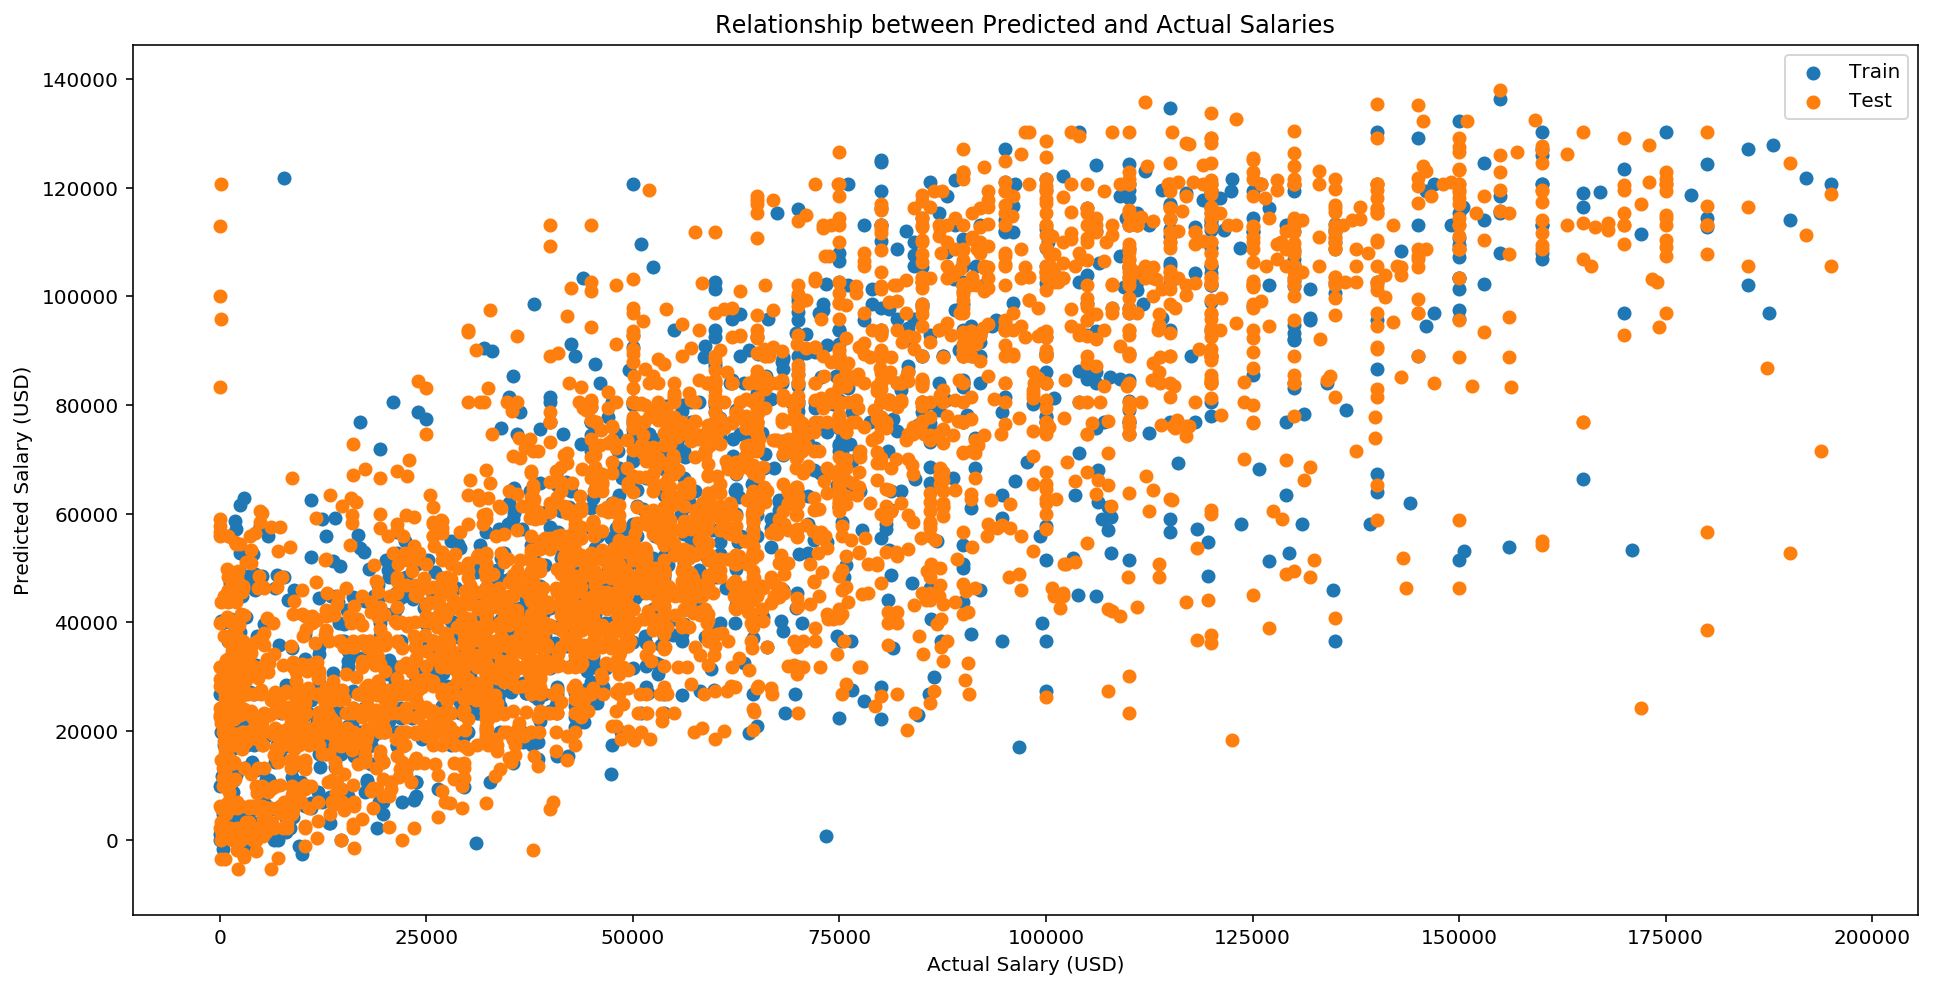

In [57]:
# Visualize the relationship between predicted and actual salaries for the test and training sets
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(y_test2, model2.predict(X_test2))
ax.scatter(y_train2, model2.predict(X_train2))
ax.legend(['Train','Test'])
ax.set_xlabel('Actual Salary (USD)')
ax.set_ylabel('Predicted Salary (USD)')
ax.set_title('Relationship between Predicted and Actual Salaries')
plt.show()

There is a much stronger correlation in both the training and testing datasets when country and number of years coded are included in the model.  Also, the fact that the testing score (0.615) is very close to the training score (0.623) gives me confidence that the model fits the features well.  Now that I have a reasonably accurate model, I can look at the feature weights for the 14 developer types and see what the independent effect of being a data scientist has on salary.

In [58]:
# Create a function to extract and display feature weights for the 14 developer types
def devtype_weights(model, X_test):
    '''
    Extract and display feature weights from the model provided for the 14 developer types
    
    model: model object from sklearn
    X_test: input testing dataset, to be used for feature names
    
    returns: weights_df, dataframe with developer type and model weights, sorted
    '''
    # Initialize DataFrame
    weights_df = pd.DataFrame()
    # Add 'DeveloperType' column
    weights_df['DeveloperType'] = X_test.columns[-14:]
    # Add 'Weights' column
    weights_df['Weight'] = model.coef_[-14:]
    
    # return sorted dataframe
    return weights_df.sort_values('Weight',ascending=False)

In [64]:
salary_weights = round(devtype_weights(model2, X_test2),2)
salary_weights

,DeveloperType,Weight
13,Machine learning specialist,10982.88
4,DevOps specialist,8472.19
7,Other,6543.82
11,Data scientist,3022.85
2,Developer with a statistics or mathematics bac...,1090.37
1,Mobile developer,831.24
0,Graphics programming,-944.20
8,Quality assurance engineer,-2505.35
3,Systems administrator,-2521.84
5,Embedded applications/devices developer,-2756.45


The weights of the developer type features is very revealing.  Since I did not normalize the salaries prior to modeling, the weights can be thought of as marginal increases (or decreases) in salary.  A developer that is a data scientist would expect to have an additional $3,022 in annual salary compared to an identical developer that is not a data scientist.  That is independent of the other developer types, where they work, or how long they have been working.  There are only three other developer types with a larger effect on salary, one of which is the catch-all 'other' type and the other two are specialists.  Interestingly enough, 'machine learning specialist' has the largest positive effect of any developer type and 'developer with a statistics or mathematics background' has the fifth largest positive effect on salary.